In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats 
import matplotlib.pyplot as plt


from statsmodels.imputation import mice
import missingno as msno
from scipy import stats
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler


from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc,ConfusionMatrixDisplay, RocCurveDisplay
)

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier


from pandas.api.types import CategoricalDtype
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
data = pd.read_csv("lending_club_loan_two.csv")

In [4]:
df = data.copy()

In [4]:
def check_df(dataset, head = 5):
    print("-"*10 + ' Shape Information of Dataset ' + "-"*10, end = '\n'*2)
    print(f" The dataset consist of {dataset.shape[0]} rows & {dataset.shape[1]} columns", end = '\n'*2)
    print("-"*10 + ' General informations about to Dataset ' + "-"*10, end = '\n'*2)
    print(dataset.info(), end = '\n'*2)
    print("-"*10 + " Are there any null values in the dataset? " + "-"*10, end = '\n'*2)
    print(dataset.isnull().sum().sort_values(ascending = False), end = '\n'*2)
    print("-"*10 + " Are there any dublicated values in the dataset? " + "-"*10, end = '\n'*2)
    print(dataset[dataset.duplicated()].shape[0], end = '\n'*2)
    print("-"*10 + " What is the Number of Unique Classes in the Variables ? " + ' ' + "-"*10, end = '\n'*2)
    print(dataset.nunique(), end = '\n'*2)
    print('-'*10 + ' Descriptive Statistics of Numerical Features ' + "-"*10, end = '\n'*2)
    print(dataset.describe().T, end = '\n'*2)
    print("-"*10 + 'Quantiles of Numerical Features' + "-"*10, end ='\n'*2)
    print(dataset.describe([0,0.25, 0.50,0.75,1.0]).T, end = '\n'*2)

In [6]:
check_df(df)

---------- Shape Information of Dataset ----------

 The dataset consist of 396030 rows & 27 columns

---------- General informations about to Dataset ----------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object

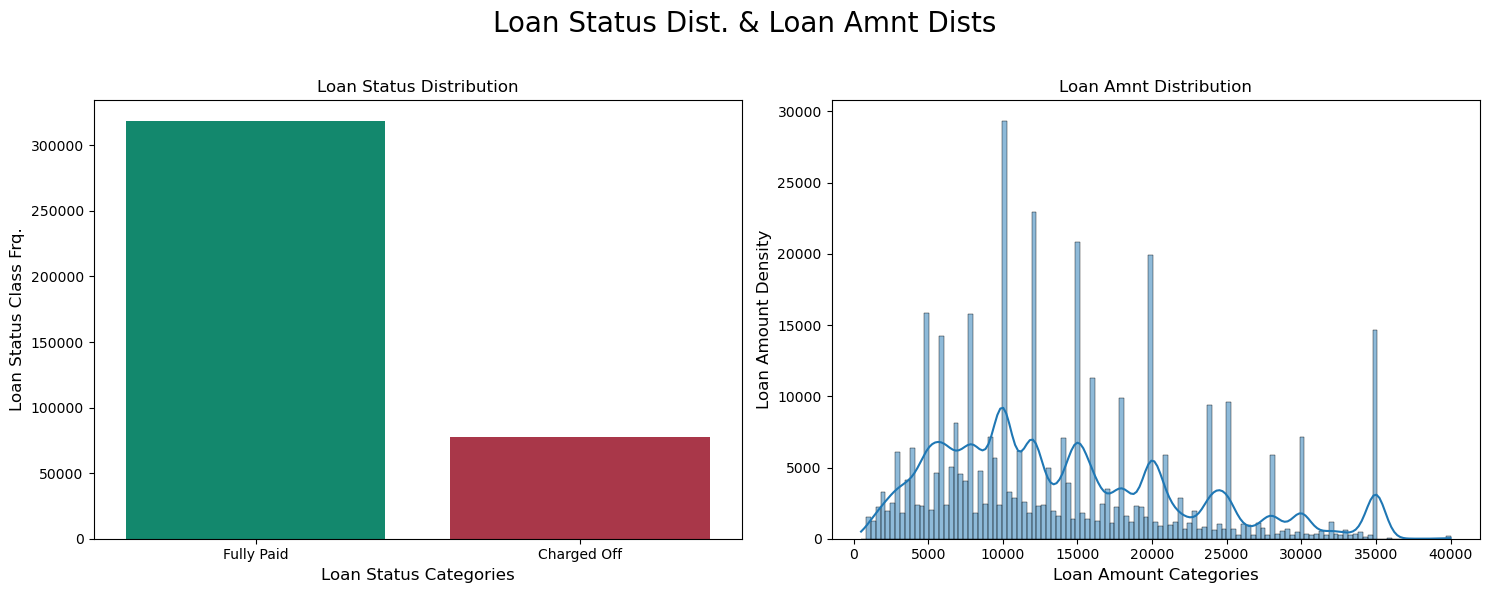

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

fig.suptitle('Loan Status Dist. & Loan Amnt Dists', fontsize = 20)
colors = ['#009B77','#BC243C']
sns.countplot(df, x = 'loan_status', ax= axes[0], palette=colors)
axes[0].set_title('Loan Status Distribution', fontsize= 12)
axes[0].set_xlabel('Loan Status Categories', fontsize = 12)
axes[0].set_ylabel('Loan Status Class Frq.', fontsize = 12)

sns.histplot(df['loan_amnt'], kde = True, ax=axes[1])
axes[1].set_title('Loan Amnt Distribution', fontsize= 12)
axes[1].set_xlabel('Loan Amount Categories', fontsize = 12)
axes[1].set_ylabel('Loan Amount Density', fontsize = 12)

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

1. Loan Status Distribution

- Observation: 

    * In the graph on the left, we can clearly see that the number of people who have fully paid off their loans (Fully Paid) is much higher than the number of people who have defaulted on their loans (Charged Off). The difference appears to be approximately 4 to 1 or 5 to 1 in terms of ratio.

- Analytical Comment: 

    * This highlights one of the most critical issues of our project from the outset: the Imbalanced Dataset Problem.

- Meaning: 

    * Since our model sees the “paid” class much more frequently, it will tend to make biased predictions toward this class. If we do not address this issue, the model we build could achieve an accuracy rate of over 80% by predicting that every loan is “likely to be paid.” However, this model would have no practical value because it would completely fail to identify risky customers, i.e., the Charged Off class, which is our primary objective.

- Note for the Roadmap: 

    * This imbalance explains why we should focus on metrics such as Precision, Recall, F1-Score, and AUC instead of accuracy during the modeling phase, and why we should use resampling techniques like SMOTE or class weights. This graph reminds us that these strategies are not “preferences” but “necessities.”

2. Loan Amount Distribution

- Observation:

    * The histogram on the right clearly shows that loan amounts (loan_amnt) do not follow a normal distribution. Instead, there are multiple peaks (multi-modal) in the distribution. There are noticeable clusters around round numbers such as 10,000, 15,000, 20,000, and 35,000.

- Analytical Interpretation: 

    * This distribution provides important insights into customer behavior and the structure of credit products:

        * Human Psychology and Demand: When applying for a loan, people typically prefer round numbers like “10,000” over “9,500.” This is the primary reason behind the peaks in the graph.

- Non-Homogeneous Customer Groups:  

    * These peak points may indicate the presence of non-homogeneous customer groups with different needs in our dataset. For example, a small peak may represent small-need loans, peaks in the 10,000-20,000 range may represent debt consolidation loans, and the largest peak at 35,000 may represent different segments such as larger investments or business loans.

- Feature Engineering Strategy:

    * Instead of directly feeding such a complex distribution of a continuous variable into the model, it is a very sensible strategy to categorize it (create loan_amnt_cat using pd.cut). This way, the model can learn these non-linear relationships more easily.


In [7]:
bins = [0, 5000, 10000, 15000, 20000, 25000, 30000, 40000]
labels = ['0-5k', '5k-10k', '10k-15k', '15k-20k', '20k-25k', '25k-30k', '30k-40k']
df['loan_amnt_cat'] = pd.cut(df['loan_amnt'], bins=bins, labels=labels)

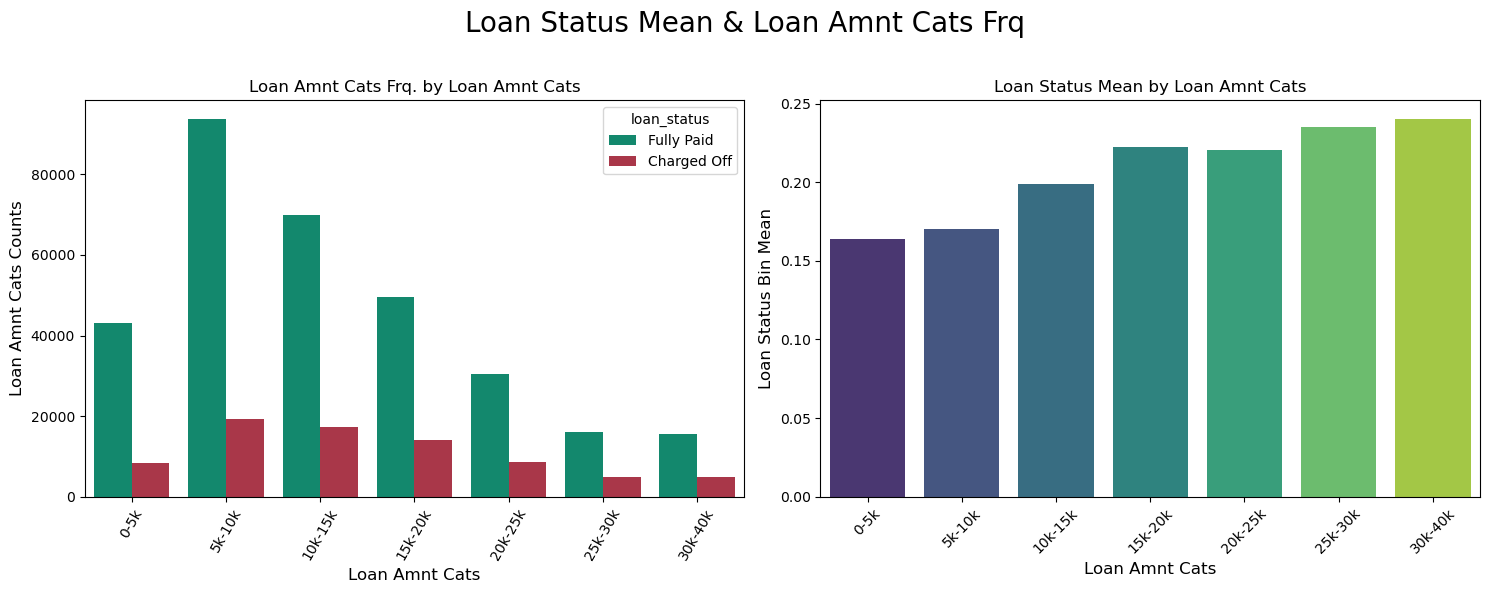

In [8]:
#df['loan_amnt_cat'] = pd.cut(df['loan_amnt'], bins=[0, 5000, 10000, 15000, 20000, 25000, 30000, 40000])

df['loan_status_bin'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})
grouped = df.groupby('loan_amnt_cat').agg({'loan_status_bin':'mean'}).reset_index().sort_values(by = 'loan_amnt_cat', ascending= True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

fig.suptitle('Loan Status Mean & Loan Amnt Cats Frq', fontsize = 20)
colors = ['#009B77','#BC243C']

sns.countplot(data=df, x='loan_amnt_cat', hue='loan_status', ax = axes[0],palette= colors)
axes[0].set_title('Loan Amnt Cats Frq. by Loan Amnt Cats', fontsize= 12)
axes[0].set_xlabel('Loan Amnt Cats', fontsize = 12)
axes[0].set_ylabel('Loan Amnt Cats Counts', fontsize = 12)
axes[0].tick_params(axis='x', rotation=60)

sns.barplot(data = grouped, x = 'loan_amnt_cat', y = 'loan_status_bin', ax = axes[1], palette= 'viridis')
axes[1].set_title('Loan Status Mean by Loan Amnt Cats', fontsize= 12)
axes[1].set_xlabel('Loan Amnt Cats', fontsize = 12)
axes[1].set_ylabel('Loan Status Bin Mean', fontsize = 12)
axes[1].tick_params(axis='x', rotation=45)



plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()


1. Frequency Distribution of Loan Amount Categories 

- Observation:

    * The most common loan amount category in the data set is the 5k-10k range. This is followed by the 10k-15k range.

    * In general, as the loan amount category increases, the total number of loans in that category decreases.

    * In each category, the number of borrowers who have fully paid off their loans (Fully Paid - green) is significantly higher than the number of those who have defaulted (Charged Off - red). This reflects the overall class imbalance we previously identified in the dataset.

- Analytical Comment:

    * This graph gives us an idea of the structure of the market by showing where credit demand is concentrated. A large portion of customers use credit between $5,000 and $15,000.

    * However, it is difficult to make a clear interpretation of how the loan amount affects the default risk based on this graph alone. Since the total number of loans in each category varies, comparing the ratios of red and green bars visually may be misleading. This is where the graph on the right comes into play and clarifies the picture.

2. Default Rate by Loan Amount Category 

- Observation:

    * In this graph, we see a very clear and strong trend: As the loan amount category increases, the average default rate (the average of loan_status_bin) in that category also increases systematically.

    * The lowest default rate is in the 0-5k category, while the highest default rate is in the 30k-40k category. The relationship is nearly linear.

- Analytical Commentary:

    * This is extremely valuable and actionable insight for our project. We can now clearly state that as the amount of credit drawn increases, so does the risk of non-repayment of that credit.

    * This finding demonstrates that you have successfully transformed the complex, multimodal structure of the loan_amnt histogram into a meaningful and interpretable trend. The categorization process (pd.cut) we performed has revealed a strong and monotonic relationship that the model can easily learn.

- Overall Assessment and Strategic Implications: 

    * When viewed together, these two graphs tell a powerful story: 
        * While credit demand is most concentrated in low-to-medium amounts, the real risk lies in higher credit amounts.


    * This feature engineering step we took (creating loan_amnt_cat) is not just a data cleaning or transformation process, but also the creation of a new feature with high predictive power that you can directly feed into your model. 

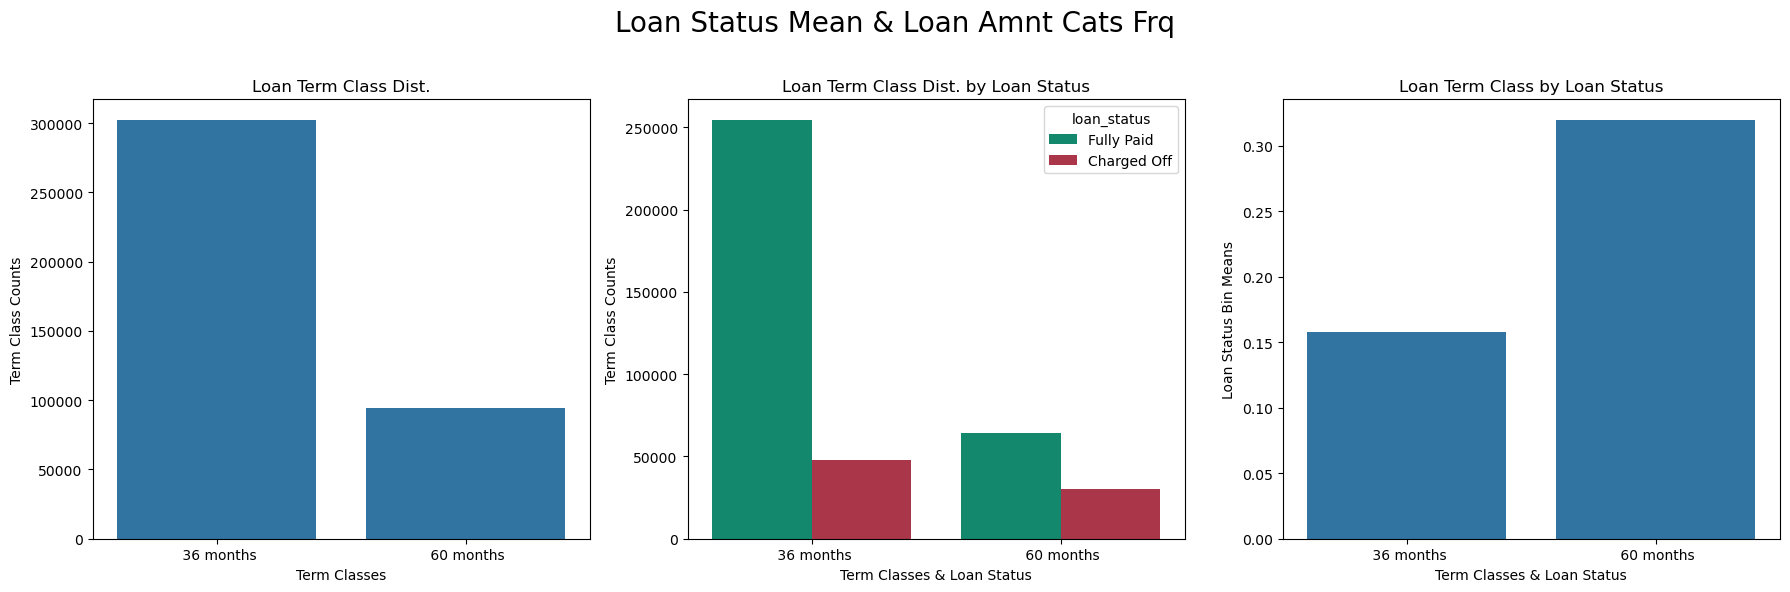

In [9]:
term_group= df.groupby('term').agg({'loan_status_bin': 'mean'}).reset_index()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

fig.suptitle('Loan Status Mean & Loan Amnt Cats Frq', fontsize = 20)
colors = ['#009B77','#BC243C']
sns.countplot(data= df, x = 'term', ax = axes[0])
axes[0].set_title('Loan Term Class Dist.', fontsize = 12)
axes[0].set_xlabel('Term Classes', fontsize = 10)
axes[0].set_ylabel('Term Class Counts', fontsize = 10)

sns.countplot(data= df, x = 'term', hue = 'loan_status',ax = axes[1], palette= colors)
axes[1].set_title('Loan Term Class Dist. by Loan Status', fontsize = 12)
axes[1].set_xlabel('Term Classes & Loan Status', fontsize = 10)
axes[1].set_ylabel('Term Class Counts', fontsize = 10)

sns.barplot(data= term_group, x = 'term', y = 'loan_status_bin', ax=axes[2])
axes[2].set_title('Loan Term Class by Loan Status', fontsize = 12)
axes[2].set_xlabel('Term Classes & Loan Status', fontsize = 10)
axes[2].set_ylabel('Loan Status Bin Means', fontsize = 10)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()


1. Credit Term Distribution:

- Observation: 

    * We see that the vast majority of credits in the data set have a maturity of 36 months (3 years). Credits with a maturity of 60 months (5 years) are in the minority. The ratio appears to be approximately 3 to 1.

- Analytical Comment: 

    * This situation indicates that shorter-term borrowing is more common in the credit market. This may be due to both borrowers' desire to pay off their debts more quickly and lenders' tendency to approve shorter-term loans more frequently, as they are considered less risky.

2. Term Distribution by Credit Status:

- Observation: 

    * We see that the number of fully paid loans (green) exceeds the number of charged-off loans (red) for both maturities. However, the ratio of the red bar (charge-offs) to its green bar for the 60-month maturity is noticeably larger than the ratio of the red bar to its green bar for the 36-month maturity.

- Analytical Comment: 

    * This graph provides the first important clue that risk differs between the two groups. We sense that the default rate may be higher for 60-month loans. However, to see these rates clearly, we need the third graph.

3. Default Rate by Loan Term (Right Graph)

- Observation:

    * This graph clearly and strongly confirms our suspicion in the previous graph. The default rate for 60-month loans is dramatically higher than the default rate for 36-month loans. According to the graph, while the default rate for 36-month loans is approximately 15-16%, this rate exceeds 35% for 60-month loans.

- Analytical Comment: 
    
    * This is a very important finding for our project. We can clearly state that as the loan term increases, the risk of default also increases exponentially.

- Possible Reasons:

    * Longer Exposure to Risk: 
        * Over a 5-year period, the likelihood of a borrower losing their job, experiencing an unexpected health issue, or encountering other financial difficulties is higher than over a 3-year period.
    
    * Riskier Customer Segment:  
        * Longer terms, such as 60 months, are typically offered to customers with larger loan amounts (which we have already identified as riskier) or lower monthly payment capacity. Therefore, the 60-month group may have accumulated a riskier customer profile from the outset.

- Overall Assessment and Strategic Conclusions

    * The term variable has proven to be an extremely powerful predictor in determining the risk of a loan, despite containing only two categories. During the modeling phase, a loan term of 60 months will be one of the most important signals for the model to flag that loan as “risky.”

    * With this simple yet effective analysis, we have placed another important building block in the foundation of our model. Great job!

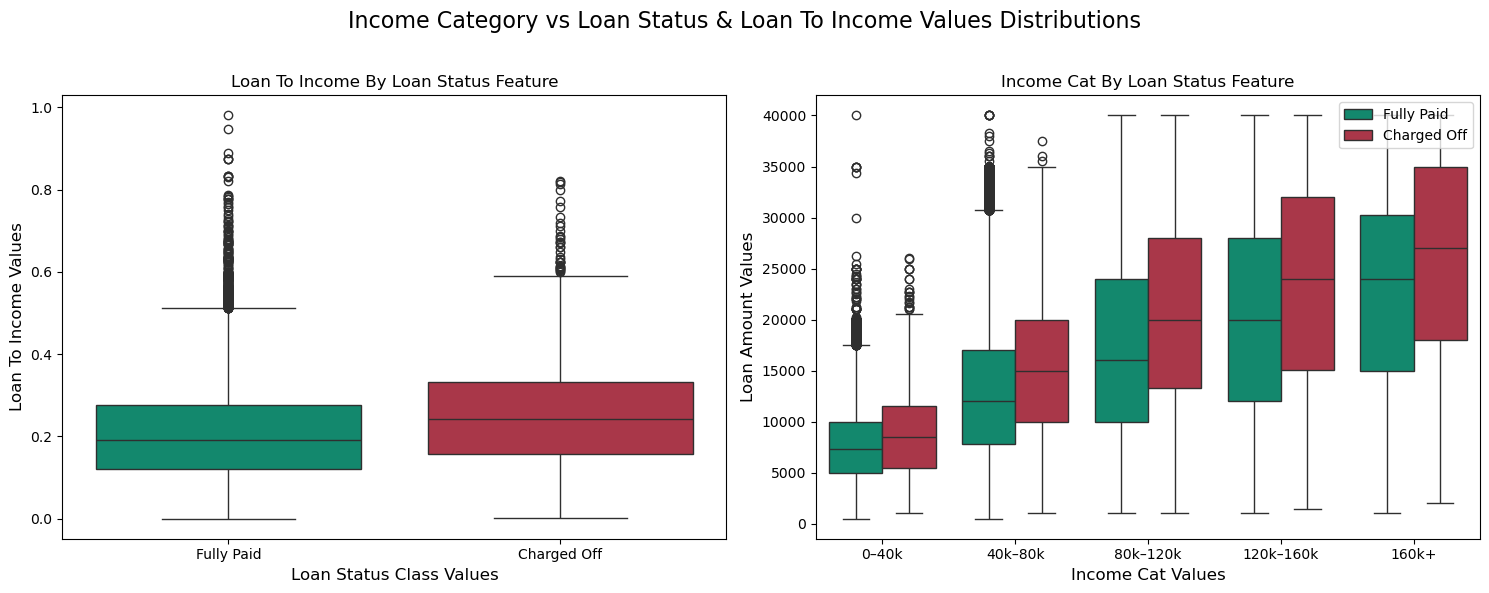

In [10]:
df['income_cat'] = pd.cut(df['annual_inc'], bins=[0, 40000, 80000, 120000, 160000, 1000000], labels=['0–40k', '40k–80k', '80k–120k', '120k–160k', '160k+'])

df['loan_to_income'] = df['loan_amnt'] / df['annual_inc']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))


fig.suptitle('Income Category vs Loan Status & Loan To Income Values Distributions', fontsize = 16)
colors = ['#009B77','#BC243C']

sns.boxplot( data=df[df['loan_to_income'] < 1],x='loan_status', y='loan_to_income', palette= colors, ax= axes[0])
axes[0].set_title('Loan To Income By Loan Status Feature', fontsize = 12)
axes[0].set_xlabel('Loan Status Class Values', fontsize = 12)
axes[0].set_ylabel('Loan To Income Values', fontsize = 12)


sns.boxplot( data=df,x='income_cat', y='loan_amnt', hue='loan_status', palette= colors, ax= axes[1])
axes[1].set_title('Income Cat By Loan Status Feature', fontsize = 12)
axes[1].set_xlabel('Income Cat Values', fontsize = 12)
axes[1].set_ylabel('Loan Amount Values', fontsize = 12)
axes[1].legend(loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show();

1. Loan Amount Distribution by Income Ratio 

- Observation: 

    * This box plot compares the distribution of the loan_to_income feature you created by loan status. We see that the box for the defaulted (Charged Off - red) group is significantly higher than the box for the fully paid (Fully Paid - green) group. The median, quartiles, and overall distribution indicate higher loan_to_income ratios for the defaulted group.

- Analytical Comment:

    * This is one of the clearest and strongest findings in the project.

    * The extent to which an individual has borrowed relative to their annual income is one of the most significant factors directly influencing their likelihood of default. This ratio directly measures the individual's debt burden or financial stress. The higher the ratio, the less flexibility remains in the individual's budget to handle unexpected circumstances (job loss, health issues, etc.).

    * The loan_to_income variable we created is a much stronger predictor than loan_amnt or annual_inc alone. This feature will play a key role in our model's classification of an individual as “risky.”

2. Credit Amount Distribution by Income Category 

- Observation: 

    * On the X-axis, from left to right, as the income category increases (from 0-40k to 160k+), both the repaid (green) and Charged off (red) loans are shifting upward along the loan_amnt (loan amount) axis.This is an expected and logical situation. It shows that as people's annual income increases, they tend to take out higher amounts of credit, and financial institutions also grant them higher limits.

    *  Within each income category, the median loan_amnt value of Charged off loans (red) is higher than the median loan_amnt value of fully repaid loans (green).This indicates that among people in the same income group, those who borrow larger amounts of credit are more likely to default. This may be an indication that individuals are stretching themselves financially beyond their means. The amount of credit borrowed is a risk factor not only in relation to income but also in relation to an individual's borrowing capacity.

    * Especially in middle-income groups such as 40k-80k and 80k-120k, the interquartile range (IQR) of defaulted loans is slightly wider than that of repaid loans. This indicates that there is greater diversity in the loan amounts among defaulters. Additionally, there are a large number of outliers in all categories.Outliers, especially at high loan amounts, can affect the performance of our model. However, they also indicate special cases where individuals have taken out loans significantly higher than expected for their income level and are either able to repay them or unable to do so.


- Analytical Commentary:

    * This graph confirms and visualizes the story told by the graph on the left from a different angle. While the graph on the left tells us that the “ratio” is important, this graph on the right shows us why this ratio is important. Whether a person is in the 40k-80k income bracket or the 160k+ income bracket, if they take out a relatively higher loan compared to others at their income level, the risk of default increases.

In summary, this graph does not simply tell us that “people with low incomes default more often.” A deeper analysis reveals that “regardless of income level, those who borrow relatively more credit for that level are at greater risk of default.”

This is evidence of how important the interaction between the annual_inc and loan_amnt variables—rather than each variable alone—might be in the model we are building (for example, the loan_to_income ratio we created).

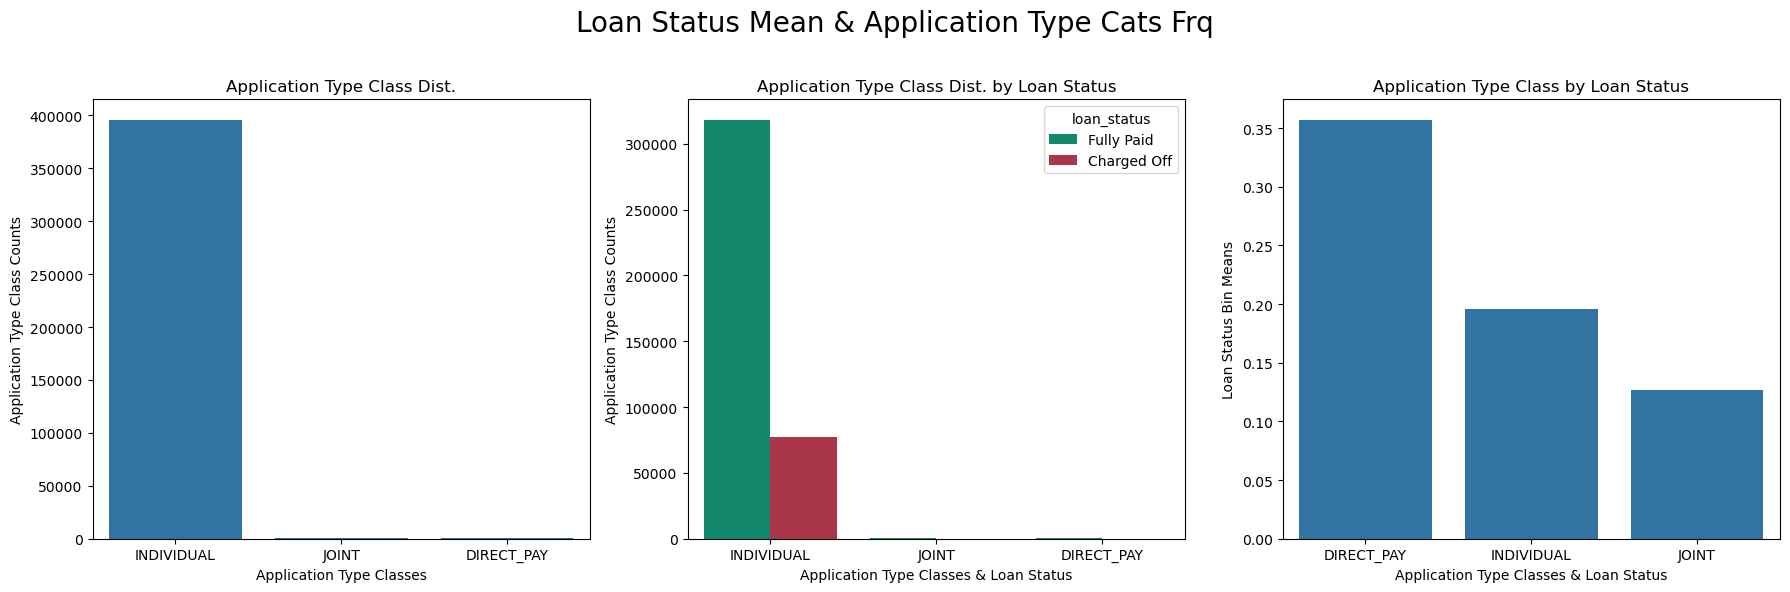

In [11]:
apptype_group= df.groupby('application_type').agg({'loan_status_bin': 'mean'}).reset_index()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

fig.suptitle('Loan Status Mean & Application Type Cats Frq', fontsize = 20)
colors = ['#009B77','#BC243C']
sns.countplot(data= df, x = 'application_type', ax = axes[0])
axes[0].set_title('Application Type Class Dist.', fontsize = 12)
axes[0].set_xlabel('Application Type Classes', fontsize = 10)
axes[0].set_ylabel('Application Type Class Counts', fontsize = 10)

sns.countplot(data= df, x = 'application_type', hue = 'loan_status',ax = axes[1], palette= colors)
axes[1].set_title('Application Type Class Dist. by Loan Status', fontsize = 12)
axes[1].set_xlabel('Application Type Classes & Loan Status', fontsize = 10)
axes[1].set_ylabel('Application Type Class Counts', fontsize = 10)

sns.barplot(data= apptype_group, x = 'application_type', y = 'loan_status_bin', ax=axes[2])
axes[2].set_title('Application Type Class by Loan Status', fontsize = 12)
axes[2].set_xlabel('Application Type Classes & Loan Status', fontsize = 10)
axes[2].set_ylabel('Loan Status Bin Means', fontsize = 10)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

1.  Individual Analysis of Graphs

- Left and Middle Graphs (Frequency Distribution):

    - Observation: 

        * These two graphs tell us one thing very clearly: the overwhelming majority of loans in the data set are from INDIVIDUAL applications. JOINT and DIRECT_PAY applications are so few that they are barely visible in the graph.

    - Analytical Comment:
        * This provides a very important context for our analysis. Any conclusions we draw about the JOINT and DIRECT_PAY categories will be based on a very small sample group.

- Right-hand graph (Charged-off Rates):

    - Observation:

        * At first glance, this graph shows that the charged-off rates for JOINT and DIRECT_PAY applications are lower than those for INDIVIDUAL applications.

    - Analytical Comment: 

        * This may make sense theoretically. For example, JOINT applications may be expected to have lower risk because two people are involved in terms of income and responsibility. However, before reaching this conclusion, we should remember our observation in the first graph.

2. Overall Assessment and Strategic Conclusions 

- When we combine these three graphs, the most important conclusion is as follows:

    * The lower default rates in the JOINT and DIRECT_PAY categories may not be statistically significant and may be misleading due to the extremely small number of samples in these groups.

    * Why is this important? An average calculated with very few data points (in this case, the default rate) can vary greatly depending on a few lucky or unlucky outcomes. For example, if there are only 10 applications in the DIRECT_PAY category and only 1 of them defaults, the rate will be 10%. But if, by chance, 2 defaulted, the rate would suddenly jump to 20%. Therefore, relying on rates derived from such small groups is risky.

    * Implications for the Model: The application_type variable may not be very useful for the model in its current form. If a feature contains nearly all the data in one of its categories (such as INDIVIDUAL), it is very difficult for the model to learn a meaningful pattern from the other categories. During the modeling phase, we might consider combining these rare categories (JOINT and DIRECT_PAY) into a single “Other” category or removing this variable from the model entirely.


In [12]:
ordered_categories = [
    '< 1 year',
    '1 year',
    '2 years',
    '3 years',
    '4 years',
    '5 years',
    '6 years',
    '7 years',
    '8 years',
    '9 years',
    '10+ years'
]

cat_type = CategoricalDtype(categories=ordered_categories, ordered=True)
df['emp_length_ordered'] = df['emp_length'].astype(cat_type)



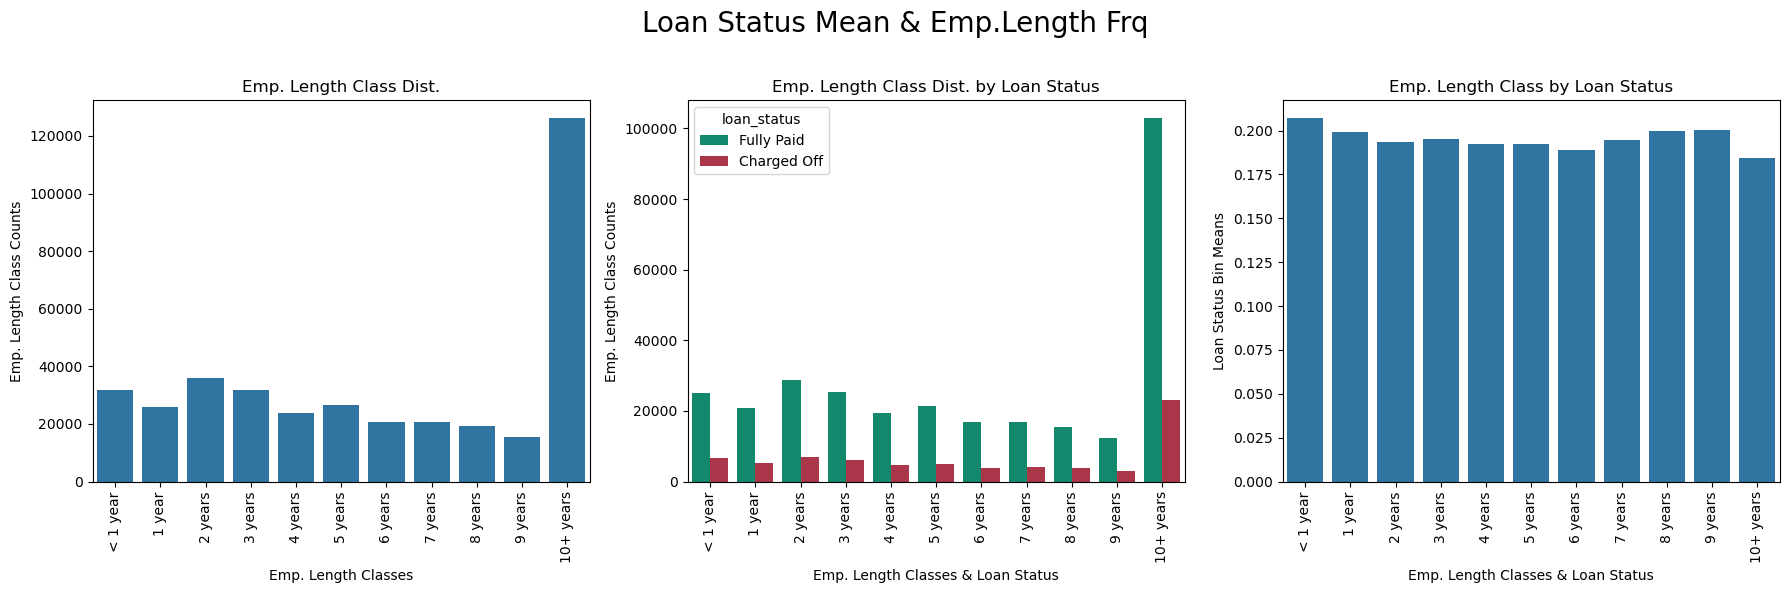

In [13]:
emplength_group= df.groupby('emp_length_ordered').agg({'loan_status_bin': 'mean'}).reset_index()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

fig.suptitle('Loan Status Mean & Emp.Length Frq', fontsize = 20)
colors = ['#009B77','#BC243C']
sns.countplot(data= df, x = 'emp_length_ordered', ax = axes[0])
axes[0].set_title('Emp. Length Class Dist.', fontsize = 12)
axes[0].set_xlabel('Emp. Length Classes', fontsize = 10)
axes[0].set_ylabel('Emp. Length Class Counts', fontsize = 10)
axes[0].tick_params(axis='x', rotation=90)

sns.countplot(data= df, x = 'emp_length_ordered', hue = 'loan_status',ax = axes[1], palette= colors)
axes[1].set_title('Emp. Length Class Dist. by Loan Status', fontsize = 12)
axes[1].set_xlabel('Emp. Length Classes & Loan Status', fontsize = 10)
axes[1].set_ylabel('Emp. Length Class Counts', fontsize = 10)
axes[1].tick_params(axis='x', rotation=90)


sns.barplot(data= emplength_group, x = 'emp_length_ordered', y = 'loan_status_bin', ax=axes[2])
axes[2].set_title('Emp. Length Class by Loan Status', fontsize = 12)
axes[2].set_xlabel('Emp. Length Classes & Loan Status', fontsize = 10)
axes[2].set_ylabel('Loan Status Bin Means', fontsize = 10)
axes[2].tick_params(axis='x', rotation=90)

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

1. Work Experience Distribution (Left and Middle Graphs)

- Observation:

    * The most striking point in both graphs is that those with 10+ years of experience constitute the largest group in the data set. Other experience periods are lower and contain similar numbers of debtors.

- Analytical Comment: 

    * A significant portion of borrowers appear to have a highly experienced and stable career profile. Looking at the middle graph, we see that the distribution of paid and defaulted loans generally follows the overall distribution across all experience levels. However, it is quite difficult to determine how risk (default rate) changes with experience from this graph.

2. Default Rate by Work Experience (Right Graph)

- Observation:

    * This graph presents us with the most interesting and unexpected result. Unlike our previous analyses (term, loan_amnt, etc.), there is no clear upward or downward trend between work experience and default rate. Default rates are very close to each other for all experience levels and fluctuate around 20%.

- Analytical Comment:  

    * This is a very important discovery for our project. Intuitively, we might have expected that people who have been working longer would be more reliable borrowers. However, the data does not support this hypothesis.  

    * When it comes to credit repayment behavior, we see that whether a person has been working for 2 years or 8 years does not make a significant difference. Default risk is nearly the same across all experience levels.

    * Perhaps a person's financial stability is already captured by other variables such as grade, annual_inc (annual income), and home_ownership (homeownership) rather than emp_length. When these variables are accounted for, work experience may not provide additional information.

The main conclusion we draw from this analysis is that work experience (emp_length) is not a strong indicator for predicting credit default risk.

This is one of the best aspects of the EDA process; we discover not only which features are important, but also which ones are not as important as expected.

Implications for the Model: The predictive power of the emp_length variable in our model is likely to be low. During the feature selection phase, we might even consider removing this variable from the model to simplify it.

Sometimes discovering that a feature is “unimportant” is just as valuable as discovering that it is important. Another great analysis completed!

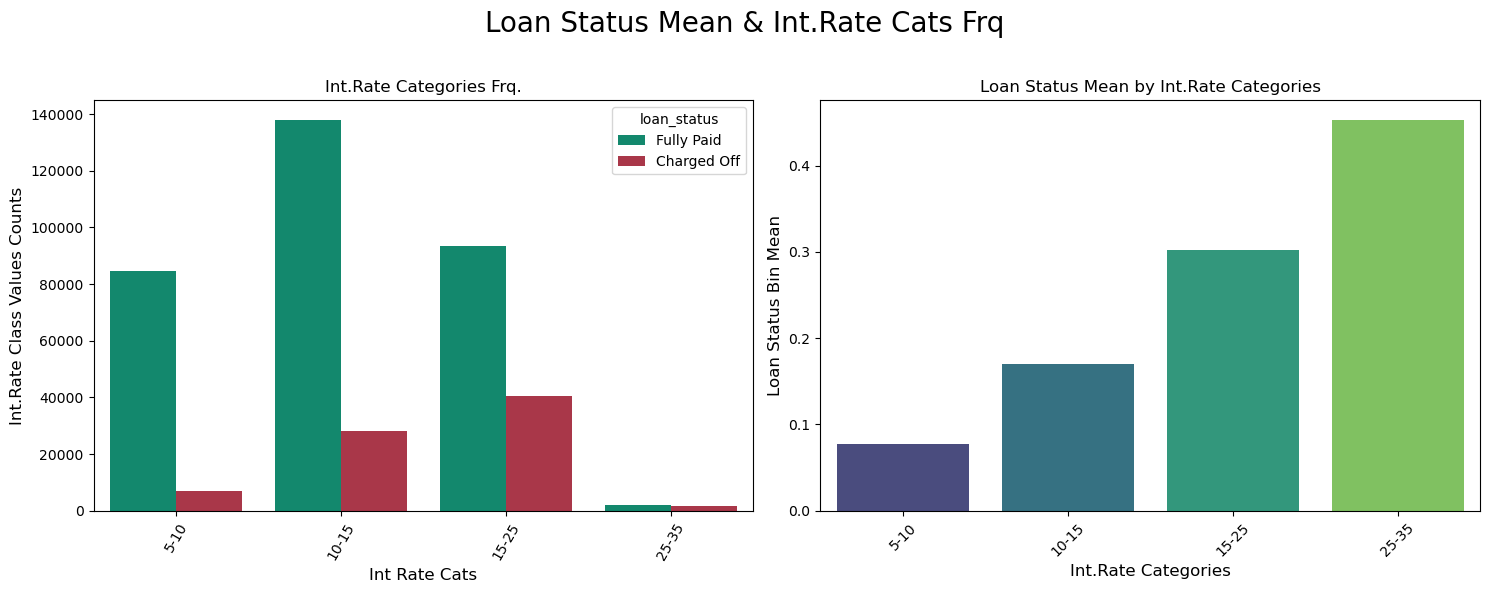

In [14]:
df['int_rate_cat'] = pd.cut(df['int_rate'], bins=[5, 10, 15, 25, 35], labels=['5-10', '10-15', '15-25', '25-35'])

int_rate_gr = df.groupby('int_rate_cat').agg({'loan_status_bin':'mean'}).reset_index().sort_values(by = 'int_rate_cat', ascending= True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

fig.suptitle('Loan Status Mean & Int.Rate Cats Frq', fontsize = 20)
colors = ['#009B77','#BC243C']

sns.countplot(data=df, x='int_rate_cat', hue='loan_status', ax = axes[0],palette= colors)
axes[0].set_title('Int.Rate Categories Frq.', fontsize= 12)
axes[0].set_xlabel('Int Rate Cats', fontsize = 12)
axes[0].set_ylabel('Int.Rate Class Values Counts', fontsize = 12)
axes[0].tick_params(axis='x', rotation=60)

sns.barplot(data = int_rate_gr, x = 'int_rate_cat', y = 'loan_status_bin', ax = axes[1], palette= 'viridis')
axes[1].set_title('Loan Status Mean by Int.Rate Categories', fontsize= 12)
axes[1].set_xlabel('Int.Rate Categories', fontsize = 12)
axes[1].set_ylabel('Loan Status Bin Mean', fontsize = 12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

1. Frequency Distribution of Interest Rate Categories (Left Graph)

- Observation: 

    * A large portion of the loans in the data set are concentrated in the 10-15% interest rate range. The 5-10% and 15-25% ranges contain fewer loans, while loans with very high interest rates, such as 25-35%, are quite rare.

- Analytical Comment:

    * This distribution reflects the general structure of the credit market. Most loans are granted to customers with an average risk profile at standard interest rates. Very low interest rates are only offered to the most reliable customers, while very high rates are only offered to customers considered the most risky. This graph shows the concentration of credit in the market rather than the risk itself.

2. Charged-Off Rate by Interest Rate Category (Right Graph)

- Observation:

    * This graph shows a very clear, strong, and gradual upward trend. As the interest rate category increases, the default rate also increases dramatically.

    * While the default risk for loans in the 5%-10% range is very low (<10%),in the 15%-25% range, this rate rises above 35%,and in the 25%-35% range, it rises above 50%.

- Analytical Comment: 

    * This is one of the clearest and strongest findings in our project. The interest rate is a direct indicator of a loan's default risk.

    * Why? This result is actually highly intuitive. Lending institutions assess a customer's risk (by considering factors such as credit score, income status, and debt levels) and apply a higher interest rate to customers they perceive as riskier to compensate for this risk. Therefore, a high interest rate is a signal that the lending institution has already labeled that customer as “risky” from the outset. This graph confirms that the institution's own risk pricing model is working.

This analysis has proven that the int_rate variable is one of the most important predictive features for our model. A high interest rate is essentially an “alarm bell” for default.

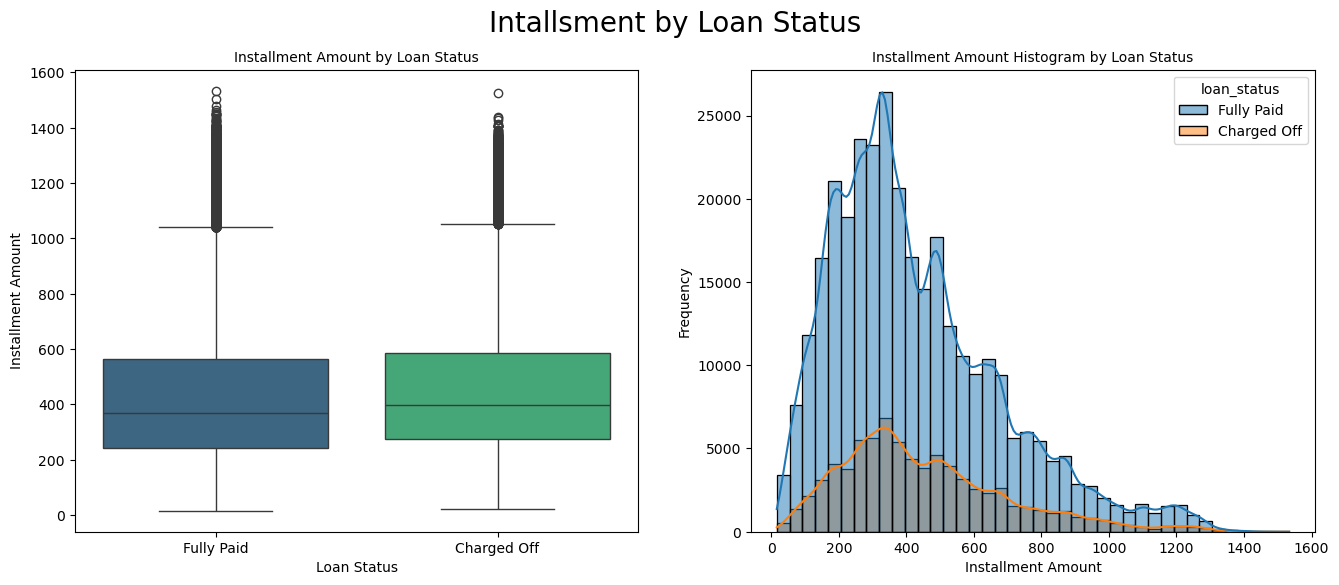

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

fig.suptitle('Intallsment by Loan Status', fontsize=20)

sns.boxplot(x='loan_status', y='installment', data=df, ax=axes[0], palette='viridis')
axes[0].set_title('Installment Amount by Loan Status', fontsize=10)
axes[0].set_xlabel('Loan Status')
axes[0].set_ylabel('Installment Amount')

sns.histplot(data=df, x='installment', hue='loan_status', kde=True, bins=40, ax=axes[1])
axes[1].set_title('Installment Amount Histogram by Loan Status', fontsize=10)
axes[1].set_xlabel('Installment Amount')
axes[1].set_ylabel('Frequency')

plt.show();

1. Box Plot Analysis (Left Graph)

- Observation: 

    * In the box plot showing the distribution of installments according to loan_status, we see that the box for the Charged Off group is positioned higher than that for the Fully Paid group. In particular, the median (the line in the middle of the box) and the third quartile (the upper line of the box) values are higher in the Charged Off group.

- Analytical Comment: 

    * This observation implies that loans with higher monthly installment amounts have a higher risk of default. This is highly logical. The higher the monthly installment amount, the more strained the borrower's monthly budget becomes, and the greater the risk of being unable to make payments in the face of an unexpected financial shock (e.g., an unexpected expense or a small decrease in income).

2. Histogram Analysis (Graph on the Right)

- Observation: 

    * The histogram shows the distribution of monthly installment amounts for both the Fully Paid and Charged Off groups in more detail.

    * The overall distribution is right-skewed, meaning that most loans have installment amounts concentrated at lower levels (<$500), but there are also a small number of loans with very high installment amounts.

    * The most important point is that the distribution curve for the Charged Off group (orange/red) is significantly shifted to the right compared to the distribution curve for the Fully Paid group (blue/green).

- Analytical Comment: 

    * This histogram not only confirms the finding in the box plot but also reinforces it. The rightward shift in the distribution confirms that defaulted loans generally have higher installment amounts at every level. This indicates a clear distinction between the two groups and demonstrates that the installment amount is a valuable feature for risk estimation.

The clear conclusion we can draw from these two graphs is that as the monthly payment burden increases, so does the risk of default.

The installment variable is not actually a standalone feature; it is a function of the loan_amnt (loan amount), int_rate (interest rate), and term (maturity) variables. In our previous analyses, we found that all three of these variables have strong relationships with default risk:

*High loan_amnt → High Risk*

*High int_rate → High Risk*

*Long term (60 months) → High Risk*

The installment variable is a very powerful predictive feature because it summarizes the combination of these three risk factors and their direct impact on the borrower in a single number. Our model will gain important insights into risk by looking at the monthly installment amount of a loan. Another great analysis!

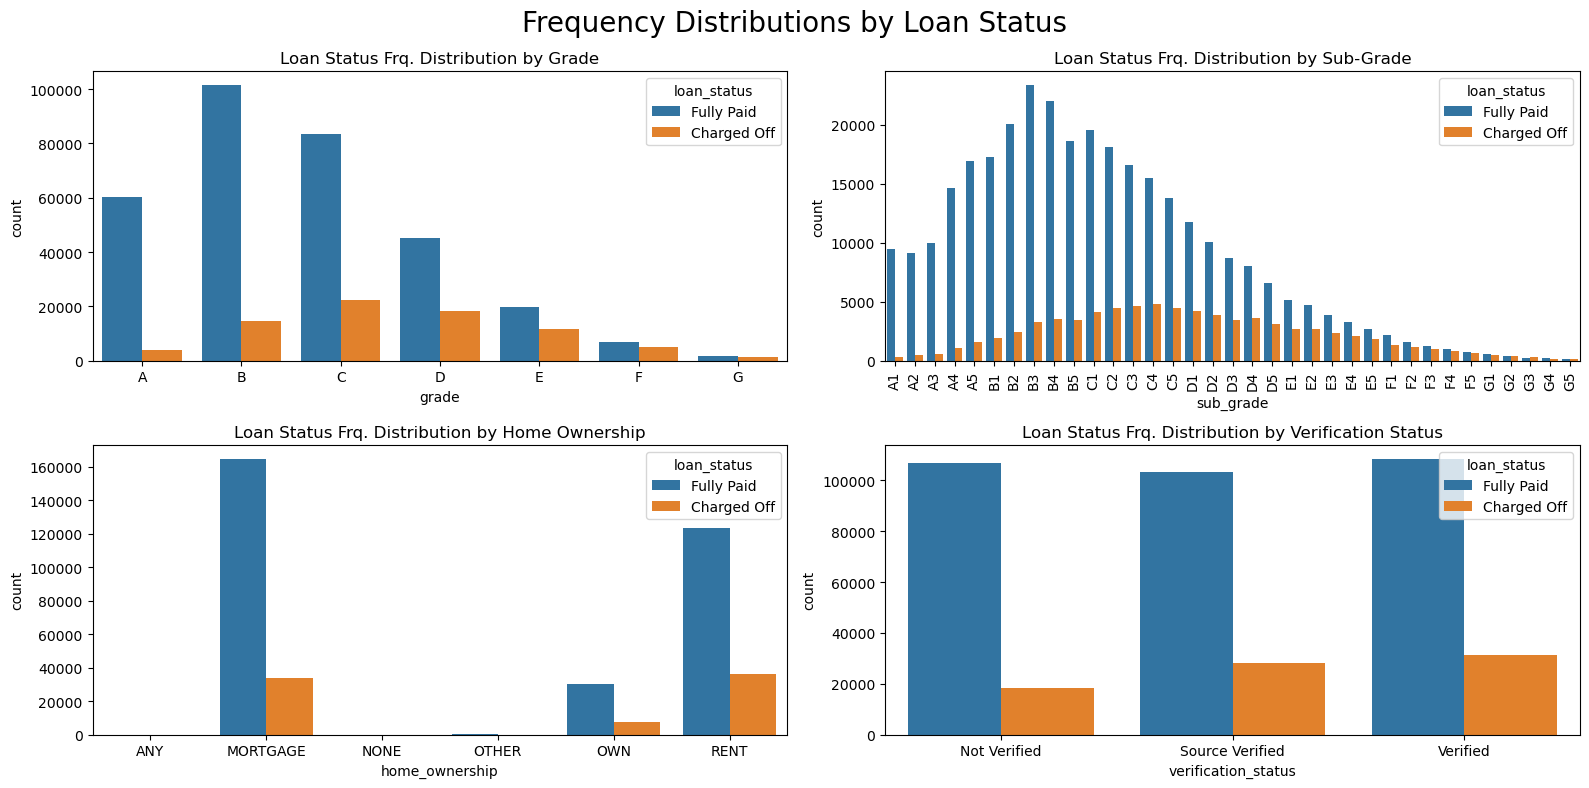

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))

fig.suptitle('Frequency Distributions by Loan Status', fontsize=20)

sns.countplot(x='grade', hue='loan_status', data=df, order=sorted(df['grade'].unique()), ax=axes[0, 0])
axes[0, 0].set_title('Loan Status Frq. Distribution by Grade')

sns.countplot(x='sub_grade', hue='loan_status', data=df, order=sorted(df['sub_grade'].unique()), ax=axes[0, 1])
axes[0, 1].set_title('Loan Status Frq. Distribution by Sub-Grade')
axes[0, 1].tick_params(axis='x', rotation=90)

sns.countplot(x='home_ownership', hue='loan_status', data=df, order=sorted(df['home_ownership'].unique()), ax=axes[1, 0])
axes[1, 0].set_title('Loan Status Frq. Distribution by Home Ownership')

sns.countplot(x='verification_status', hue='loan_status', data=df, order=sorted(df['verification_status'].unique()), ax=axes[1, 1])
axes[1, 1].set_title('Loan Status Frq. Distribution by Verification Status')

plt.tight_layout(rect=[0, 0, 1, 1])

plt.show()

1. Loan Status Frequency Distribution by Grade
    - Observation:

        * The vast majority of loans in the data set are concentrated in grades B and C.

        * As the credit grade deteriorates from ‘A’ to ‘G’, the height of the blue bars (Fully Paid) decreases, while the height of the orange bars (Charged Off) increases up to a certain point and then decreases. However, the most important point is that the ratio of the orange bar to the blue bar increases steadily from A to G.

    - Analytical Comment:

        * This graph clearly shows that the credit rating system (grade) is working as expected. Grade is a very powerful indicator of a customer's risk of default.

        * Customers with better grades such as A and B have a much higher probability of repaying their loans, while customers with grades such as F and G have a dramatically higher risk of default.

        * This is one of the clearest signs that the grade variable will have a very high predictive power during the modeling phase.

2. Loan Status Frequency Distribution by Sub-Grade
    - Observation:

        * This graph is a more detailed version of the grade graph. We see that loans are mostly concentrated in sub-grades such as B3, B4, C1, and C2.

        * The trend in the grade graph continues here in a smoother and more pronounced manner. As we move from A1 to G5, we observe that the default (orange) rate increases almost gradually.

    - Analytical Comment:

        * sub_grade provides a more granular (detailed) risk segmentation than grade. For example, it shows a clear difference in risk profiles between a C1 customer and a C5 customer.

        * This suggests that the sub_grade variable may be even more useful than grade for the model to make more accurate predictions. During the modeling phase, we can decide which of these two variables to use or how to integrate both.

3. Loan Status Distribution by Home Ownership
    - Observation:

        * The vast majority of borrowers are either homeowners (MORTGAGE) or renters (RENT). A very small portion are owners of their own homes (OWN). There is almost no data in categories such as ANY and OTHER.

        * The default rate for renters (RENT) (the ratio of the orange bar to the blue bar) is noticeably higher than that of homeowners (MORTGAGE). The situation for those who own their own homes (OWN) appears to fall between these two.

    - Analytical Comment:

        * Homeownership status provides an important clue about financial stability. Since owning a home with a mortgage typically indicates regular payment discipline and a more stable financial situation, it makes sense that these individuals have a lower default risk.

        * Renters may have higher risks because they may have less financial security.

        * The home_ownership variable will also be a meaningful feature for the model.

4. Loan Status Frequency Distribution by Verification Status
    - Observation:

        * The data set is fairly evenly distributed across three categories: Verified, Source Verified, and Not Verified.

        * Interestingly, the default rate for those with verified income (Verified) appears to be higher than that for those with unverified income (Not Verified). Source Verified has a risk profile between the two.

    - Analytical Comment:

        * At first glance, this may seem counterintuitive. It raises the question, “Why would someone with verified income default more often?” One possible explanation could be selection bias. The lending institution may subject the incomes of applicants it already perceives as riskier or who show inconsistencies in their application information to stricter verification. In other words, the Verified group may already consist of a riskier population from the outset.

        * This is a great example of how looking at a single variable can be misleading and how important the interaction between variables can be.

Now, to validate the insights we have gained here, we will examine our categorical variables based on the average of the “loan_status_bin” variable we created earlier and support our assumptions.


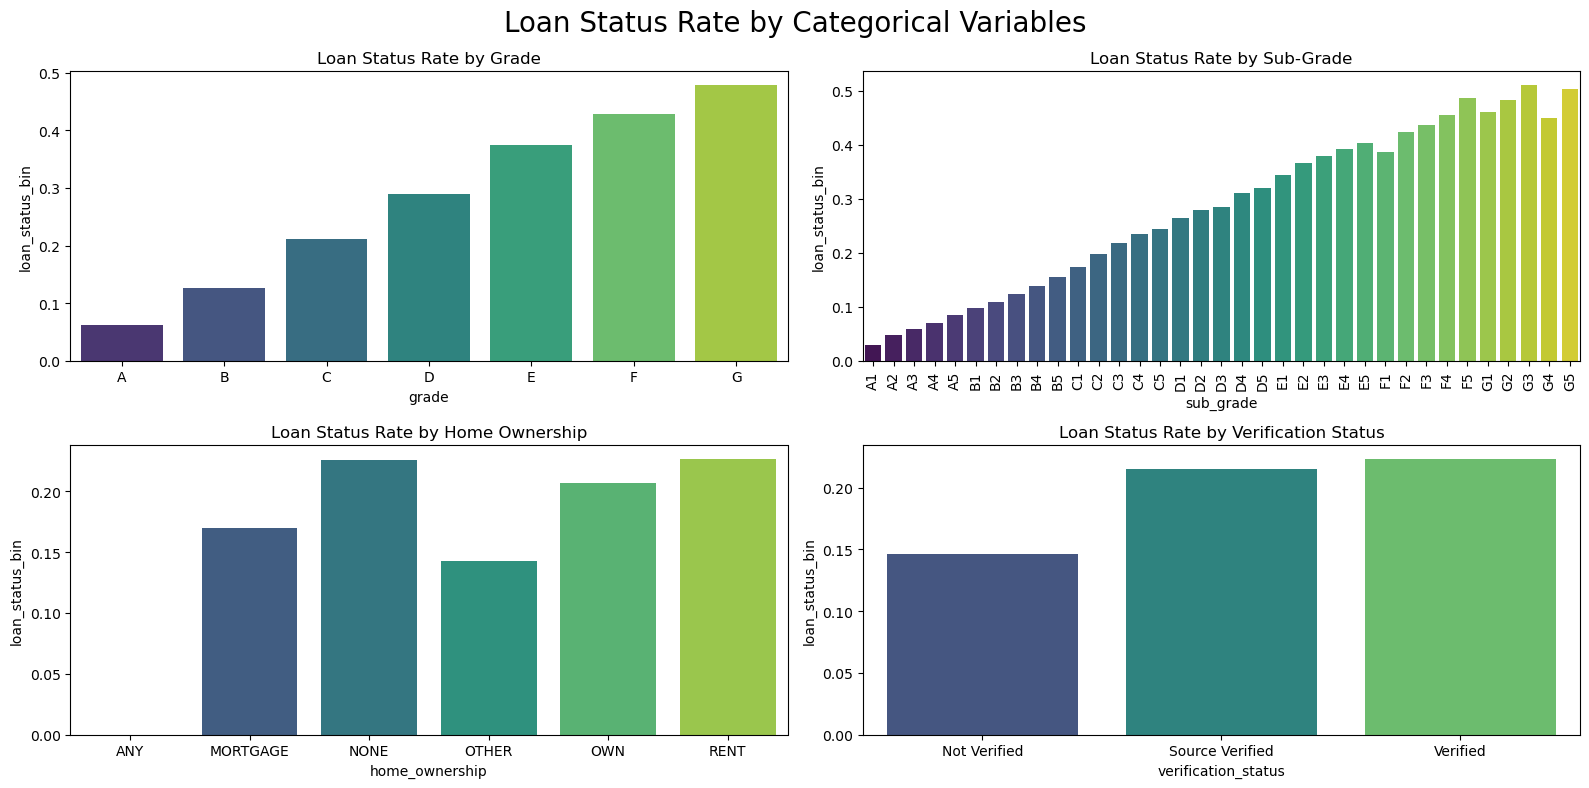

In [17]:
grade_rate = df.groupby(['grade']).agg({'loan_status_bin':'mean'}).reset_index().sort_values(by='grade', ascending = True)
sub_grade_rate = df.groupby(['sub_grade']).agg({'loan_status_bin':'mean'}).reset_index().sort_values(by='sub_grade', ascending = True)
homow_rate = df.groupby(['home_ownership']).agg({'loan_status_bin':'mean'}).reset_index().sort_values(by='home_ownership', ascending = True)
verstat_rate = df.groupby(['verification_status']).agg({'loan_status_bin':'mean'}).reset_index().sort_values(by='verification_status', ascending = True)


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))

fig.suptitle('Loan Status Rate by Categorical Variables', fontsize=20)

sns.barplot(x='grade', y='loan_status_bin', data=grade_rate, order=sorted(grade_rate['grade'].unique()), ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Loan Status Rate by Grade')

sns.barplot(x='sub_grade', y='loan_status_bin', data=sub_grade_rate, order=sorted(sub_grade_rate['sub_grade'].unique()), ax=axes[0, 1], palette='viridis')
axes[0, 1].set_title('Loan Status Rate by Sub-Grade')
axes[0, 1].tick_params(axis='x', rotation=90)

sns.barplot(x='home_ownership', y='loan_status_bin', data=homow_rate, order=sorted(homow_rate['home_ownership'].unique()), ax=axes[1, 0], palette='viridis')
axes[1, 0].set_title('Loan Status Rate by Home Ownership')

sns.barplot(x='verification_status', y='loan_status_bin', data=verstat_rate, order=sorted(verstat_rate['verification_status'].unique()), ax=axes[1, 1], palette='viridis')
axes[1, 1].set_title('Loan Status Rate by Verification Status')

plt.tight_layout(rect=[0, 0, 1, 1])

plt.show()

1. Charged-Off Rate by Loan Status Grade

- Confirmed Conclusion: In the previous graph, we observed that the default rate increased as the grade deteriorated. This graph confirms this observation numerically and shows how sharp the increase is.

- Analytical Comment:

    * While the default rate for an A grade is around 5%, for a G grade it exceeds 40%. This is a monotonic relationship showing that risk increases exponentially with grade (as one variable increases, the other increases continuously).

    * We can clearly see how powerful a discriminating feature grade is on its own. This is a strong candidate to be one of the most important features of our model.

2. Charged-Off Rate by Sub-Grade

- Confirmed Conclusion: This graph perfectly supports our hypothesis that sub_grade provides a more sensitive risk differentiation than grade.

- Analytical Comment:

    * The increase in the default rate rises almost seamlessly from A1 to G5. This proves that sub_grade captures credit risk at a much more granular level.

    * For example, knowing whether a customer is C1 or C5, rather than just ‘C,’ provides our model with much more information for predicting default risk. This graph suggests that sub_grade could be a stronger feature than grade.

3. Charged-Off Rate by Home Ownership Status

- Confirmed Conclusion: This clarifies our conclusion that MORTGAGE holders have the lowest risk and RENT (tenants) have the highest risk.

- Analytical Comment:

    * The graph quantifies the risk difference between these groups. The default rate for MORTGAGE holders is approximately 15%, while that for tenants is around 22%. This indicates that the difference between the two is statistically significant.

    * Important Note: Although the rates for the OTHER, NONE, and ANY categories appear very high, we know from the previous frequency graph that there are very few people in these categories. Therefore, these high rates may be due to small sample sizes and could be misleading. It is more reliable to focus on MORTGAGE, RENT, and OWN in our analyses.

4. Charged-Off Rate by Verification Status

- Verified Conclusion: Our hypothesis of “selection bias”—that those with verified income have the highest default rate—is clearly proven here.

- Analytical Comment:

    * This graph presents one of the most interesting and counterintuitive findings. Unverified (~15% rate) has the lowest risk, while Verified (~22% rate) has the highest risk.

    * This strongly confirms that the credit institution is inclined to verify profiles it deems risky. When using this variable in the model, we should keep in mind that the “verified” factor may actually be a proxy for an underlying higher risk profile.


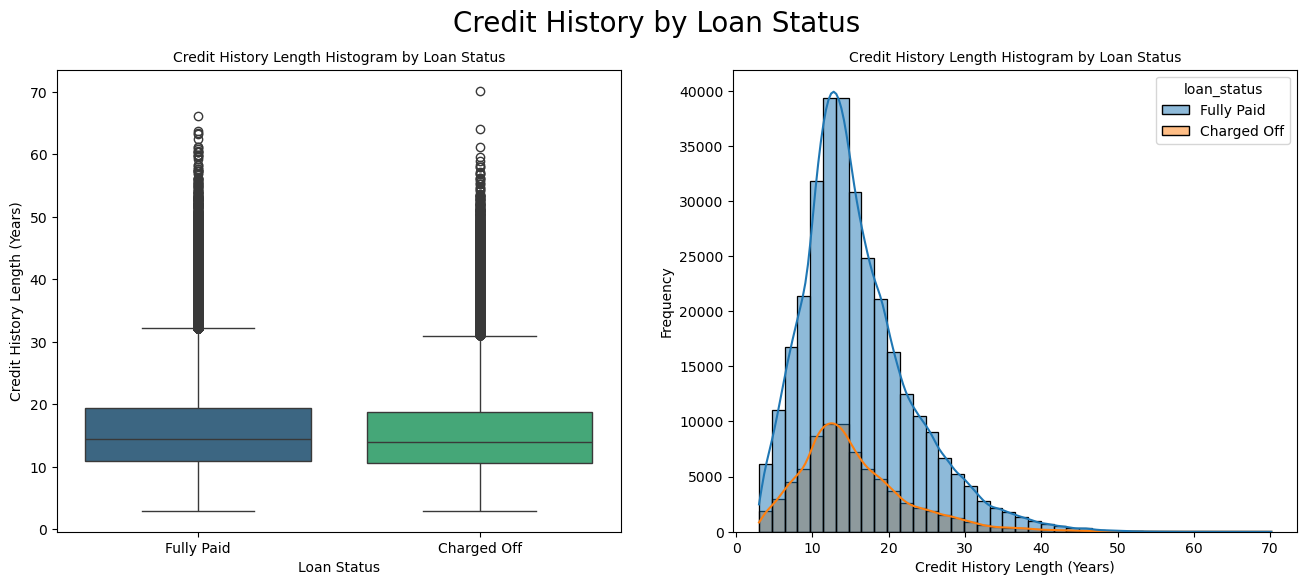

In [18]:
df['credit_history_length'] = ( pd.to_datetime(df['issue_d'], format='%b-%Y') - pd.to_datetime(df['earliest_cr_line'], format='%b-%Y') ).dt.days / 365.25

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

fig.suptitle('Credit History by Loan Status', fontsize=20)

sns.boxplot(x='loan_status', y='credit_history_length', data=df, ax=axes[0], palette='viridis')
axes[0].set_title('Credit History Length Histogram by Loan Status', fontsize=10)
axes[0].set_xlabel('Loan Status')
axes[0].set_ylabel('Credit History Length (Years)')

sns.histplot(data=df, x='credit_history_length', hue='loan_status', kde=True, bins=40, ax=axes[1])
axes[1].set_title('Credit History Length Histogram by Loan Status', fontsize=10)
axes[1].set_xlabel('Credit History Length (Years)')
axes[1].set_ylabel('Frequency')

plt.show();

Credit History Length

- Observations:
    * In both graphs, we see that the distribution of credit history length for those who paid off their credit in full (Fully Paid) shifts slightly to the right compared to those who defaulted (Charged Off). This indicates that successful borrowers generally tend to have slightly longer credit histories.

    * The median line (the line inside the box) in the box plot is higher for the Fully Paid group than for the Charged Off group.

    * However, there is a significant overlap between the distributions of the two groups. This indicates that it is challenging to predict whether an individual will default based solely on the length of their credit history.

- Statistical Analysis:
    * Numerical data confirms and clarifies our observations in the visuals

    * Mean: The average credit history of those who paid their loans is 15.85 years, while the average for those who defaulted is 15.36 years.

    * Median (50%): The median value for those who paid off their loans is 14.49 years, while for those who defaulted, it is 13.92 years.

- Analytical Interpretation and Conclusion
    * The most important insight we gain from this analysis is that a longer credit history is associated with a lower risk of default, but this relationship is not very strong.

Why is it logical? A long credit history can indicate that a person has been part of the financial system for a longer period of time, is more experienced in using credit products, and potentially has a more stable financial history. Therefore, it is reasonable to expect that these individuals are slightly more likely to repay their debts.

What Does It Mean for the Model? While the credit_history_length variable may not be a very strong predictor on its own, it is a useful feature that will certainly contribute to our model. It will likely become more meaningful when combined with other variables (e.g., age, income, credit score).

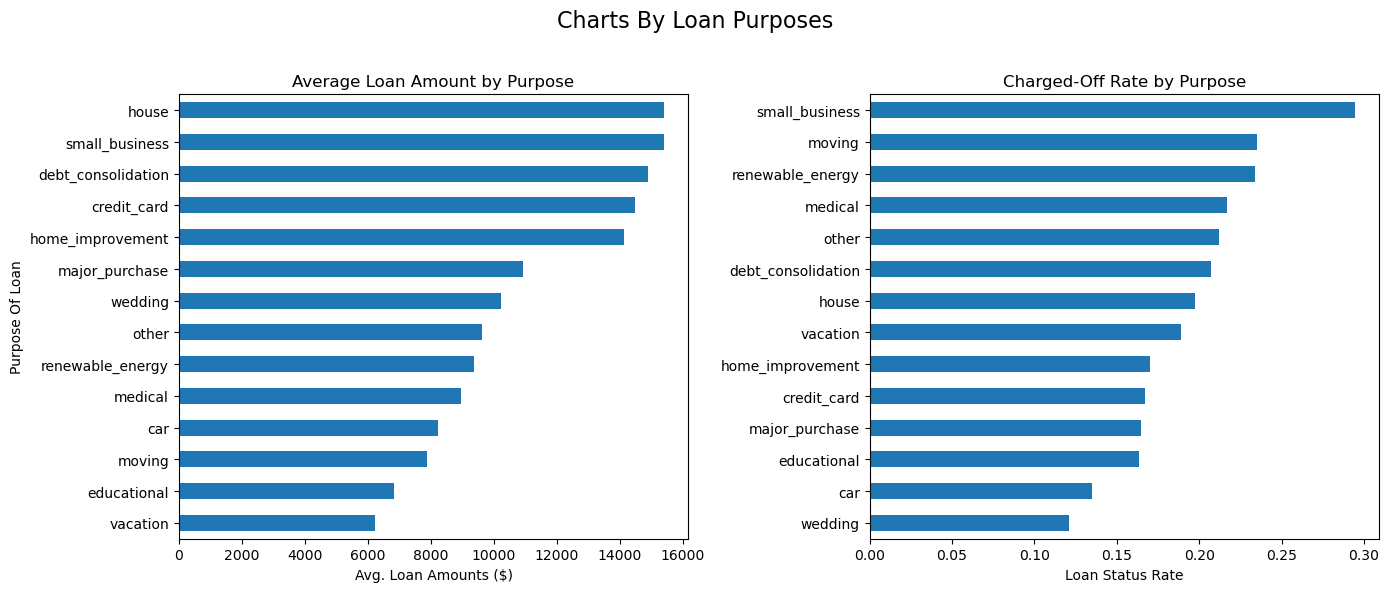

In [19]:
grouped = df.groupby('purpose')['loan_amnt'].mean().sort_values()
purpose_defaults = df.groupby('purpose')['loan_status_bin'].mean().sort_values()


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
grouped.plot(kind='barh', ax=axes[0], title='Average Loan Amount by Purpose')
axes[0].set_xlabel('Avg. Loan Amounts ($)')
axes[0].set_ylabel('Purpose Of Loan')


purpose_defaults.plot(kind='barh', title='Charged-Off Rate by Purpose')
axes[1].set_xlabel('Loan Status Rate')
axes[1].set_ylabel('') 

fig.suptitle('Charts By Loan Purposes', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

1. Average Loan Amounts (Left Graph)

- Observation: 

    * This graph shows how much credit was taken out for what purposes. Loans for small businesses, houses, credit card debt restructuring, and debt consolidation have the highest average amounts. In contrast, loans for purposes such as educational, moving, and vacation have lower amounts.

- Analytical Comment: 

    * These results are quite intuitive. Major investments such as starting a business or buying a home naturally require more capital than expenses related to a vacation or moving. This graph gives us an idea of the financial scale of each purpose.

2. Charged-Off Rates (Right Graph)

- Observation: 

    * This graph shows the risk profile of each purpose. small_business has by far the highest default rate. It is followed by purposes such as educational, renewable_energy, and moving. On the other hand, credit_card (credit card), wedding (wedding), and home_improvement (home improvement) stand out as the lowest-risk categories.

- Analytical Comment: 

    * This graph shows how critical the primary purpose is when assessing credit risk. The uncertainties associated with starting a business make small business loans the riskiest category.

3. Comparative Analysis of Two Graphs 

    * The true power of these two graphs becomes apparent when we interpret them together:

        * The ‘small_business’ Dilemma: High Amount, Highest Risk

            - small_business has both the highest average loan amount and the highest default rate. This translates to “high risk, high amount” for the lending institution and is potentially the most dangerous type of loan.

        * The Two Faces of Debt Restructuring: ‘credit_card’ vs. 'debt_consolidation'

            - This is one of the most interesting findings. Both purposes aim to consolidate existing debts under one roof, and both involve borrowing large amounts of credit (left graph).

            - However, when we look at the risk profiles (right graph), restructuring credit card debt is one of the lowest-risk purposes, while general debt consolidation is a medium-to-high-risk purpose.

            - Conclusion: 
                * This suggests that restructuring credit card debt is typically done by a more reliable customer profile with higher financial discipline who is trying to manage their debt. General “debt consolidation,” on the other hand, may encompass a more complex and financially distressed, and therefore riskier, group.

        * Low Amount Does Not Always Mean Low Risk

            - Loans for educational and moving purposes, despite having low average amounts, rank high on the default rate list.

            - Conclusion: 
                * This shows that credit risk is not only related to the amount of money borrowed, but also to the life circumstances brought about by the actual purpose. Situations such as education or moving are often associated with periods of high financial uncertainty (e.g., a graduate who has not yet found a job).

In [20]:
def desc_stats(dataframe):
    desc = dataframe.describe(percentiles =[0, 0.25, 0.50, 0.75, 0.85, 0.95, 0.99, 1]).T
    desc_df = pd.DataFrame(index= dataframe.columns, 
                           columns= desc.columns,
                           data= desc)
    
    f,ax = plt.subplots(figsize=(20,
                                 desc_df.shape[0]*0.78))
    sns.heatmap(desc_df,
                annot=True,
                cmap = "Wistia",
                fmt= '.2f',
                ax=ax,
                linecolor='white',
                linewidths = 1.3,
                cbar = False,
                annot_kws={"size": 12})
    plt.xticks(size = 18)
    plt.yticks(size = 14,
               rotation = 0)
    plt.title("Descriptive Statistics", size = 14)
    plt.show()

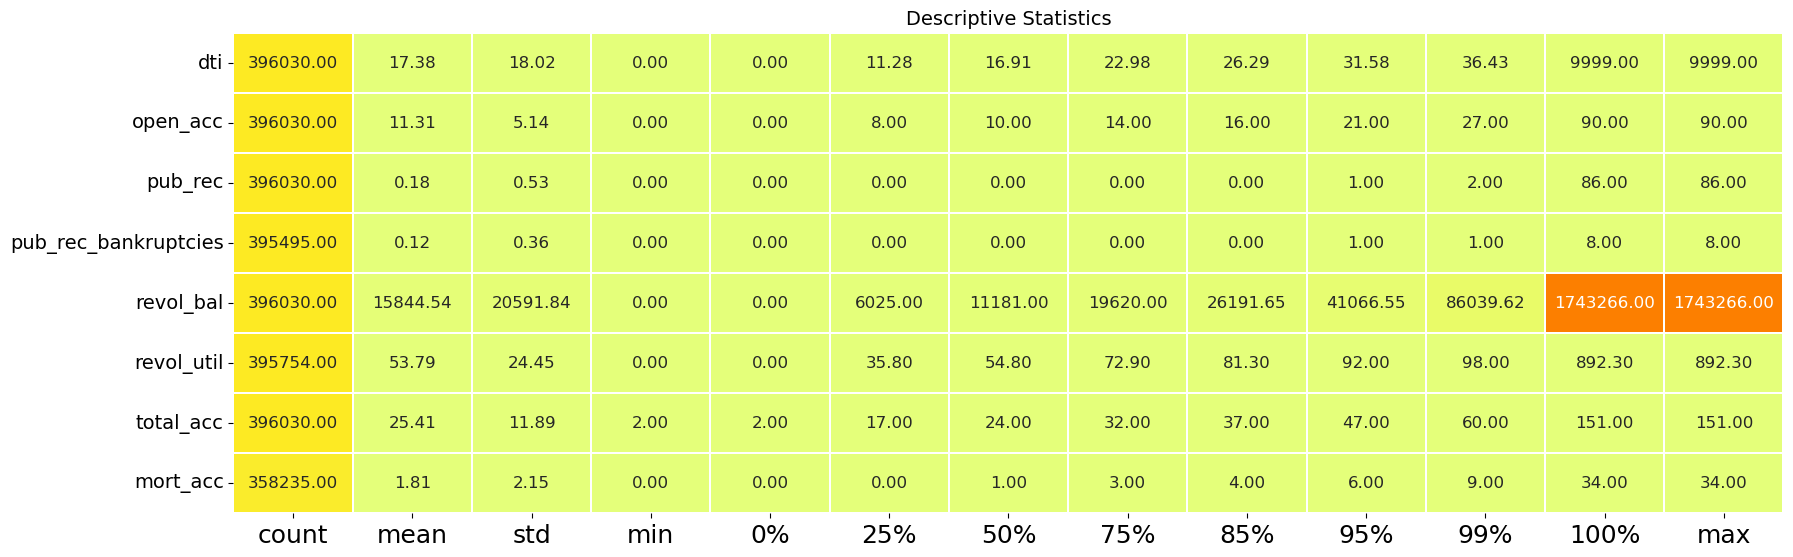

In [21]:
desc_stats(df[['dti', 'open_acc', 'pub_rec','pub_rec_bankruptcies' ,'revol_bal','revol_util', 'total_acc', 'mort_acc' ]])

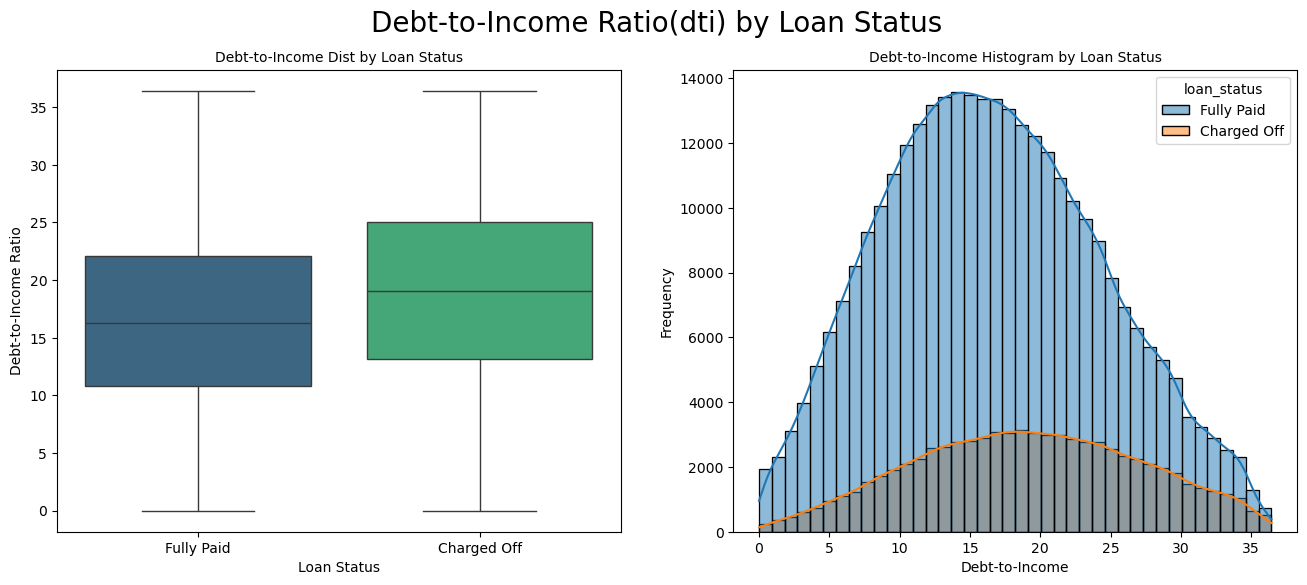

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

fig.suptitle('Debt-to-Income Ratio(dti) by Loan Status', fontsize=20)

sns.boxplot(x='loan_status', y='dti', data=df[df['dti']<=df['dti'].quantile(0.99)], ax=axes[0], palette='viridis')
axes[0].set_title('Debt-to-Income Dist by Loan Status', fontsize=10)
axes[0].set_xlabel('Loan Status')
axes[0].set_ylabel('Debt-to-Income Ratio')

sns.histplot(data=df[df['dti']<=df['dti'].quantile(0.99)], x='dti', hue='loan_status', kde=True, bins=40, ax=axes[1])
axes[1].set_title('Debt-to-Income Histogram by Loan Status', fontsize=10)
axes[1].set_xlabel('Debt-to-Income')
axes[1].set_ylabel('Frequency')

plt.show();

1. Box Plot Analysis (Left Graph)

- Observation: 

    * In the box plot showing the distribution of DTI (debt-to-income ratio) by loan_status, we see that the box for the Charged Off group is significantly higher than that for the Fully Paid group. The entire distribution, including the median, lower quartile, and upper quartile, indicates higher DTI ratios for those in default.

- Analytical Comment: 

    * This clearly shows a positive relationship between DTI and default risk. In other words, the higher a person's current debt-to-income ratio, the greater the likelihood that they will be unable to repay their new loan. This makes perfect sense, as a high DTI indicates that the individual has less financial flexibility and that their monthly budget is already strained. In such a situation, even the slightest financial shock could leave the borrower unable to repay their loan.

2. Histogram Analysis (Right Graph)

- Observation: 

    * The histogram confirms this relationship in more detail. We see that the distribution curve for the Charged Off group (usually orange/red according to the color palette) has shifted noticeably to the right compared to the curve for the Fully Paid group. The peak of the Charged Off group occurs at a higher dti value than the peak of the Fully Paid group.

- Analytical Comment: 

    * This rightward shift in the distribution reinforces the finding that defaulted borrowers generally have higher debt-to-income ratios. This graph visually demonstrates how effective DTI is as a feature in distinguishing between the two classes.

- Overall Assessment and Strategic Implications

    *The conclusion we draw from these two graphs is clear: DTI (Debt-to-Income Ratio) is a strong predictor of credit risk and is of critical importance in determining credit risk.*

    * Implications for the Model: The machine learning model we will build will learn to associate higher DTI values with higher default probabilities. This feature is expected to rank high in the model's feature importance ranking.

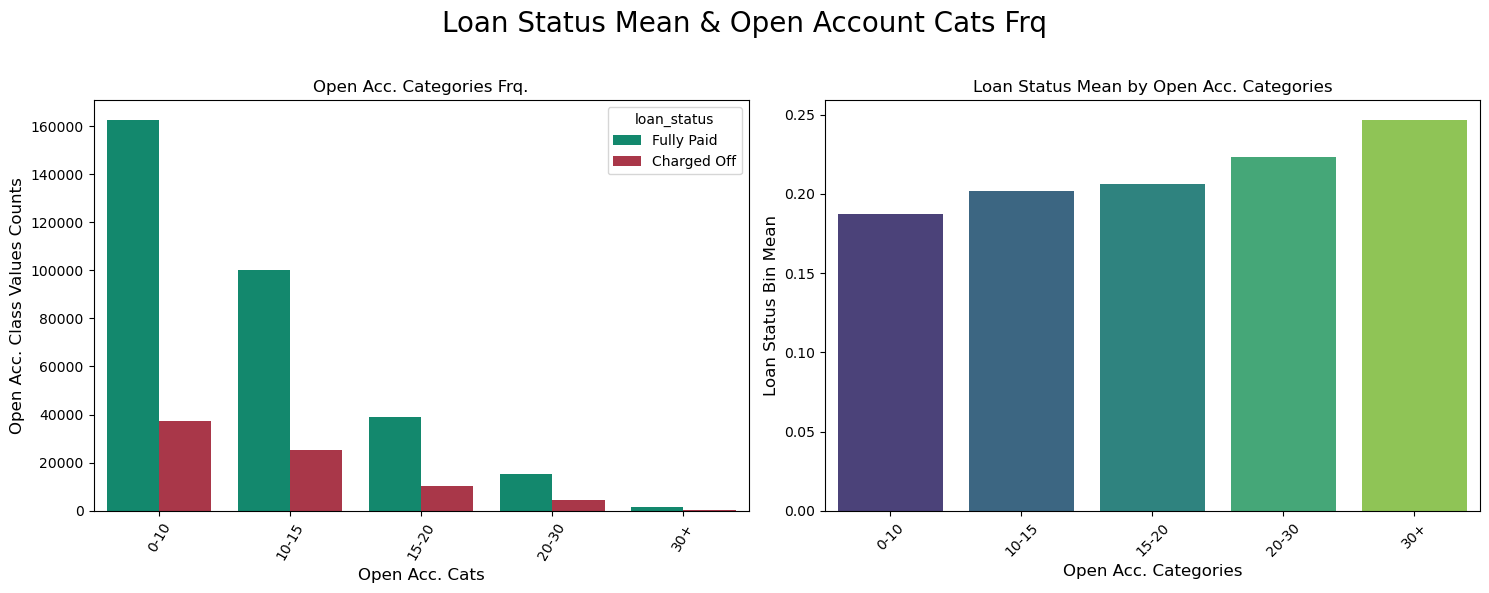

In [ ]:
df['open_acc_cat'] = pd.cut(df['open_acc'], bins=[0, 10, 15, 20, 30,float('inf')], labels=['0-10', '10-15', '15-20', '20-30', '30+'])

open_acc_gr = df.groupby('open_acc_cat').agg({'loan_status_bin':'mean'}).reset_index().sort_values(by = 'open_acc_cat', ascending= True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

fig.suptitle('Loan Status Mean & Open Account Cats Frq', fontsize = 20)
colors = ['#009B77','#BC243C']

sns.countplot(data=df, x='open_acc_cat', hue='loan_status', ax = axes[0],palette= colors)
axes[0].set_title('Open Acc. Categories Frq.', fontsize= 12)
axes[0].set_xlabel('Open Acc. Cats', fontsize = 12)
axes[0].set_ylabel('Open Acc. Class Values Counts', fontsize = 12)
axes[0].tick_params(axis='x', rotation=60)

sns.barplot(data = open_acc_gr, x = 'open_acc_cat', y = 'loan_status_bin', ax = axes[1], palette= 'viridis')
axes[1].set_title('Loan Status Mean by Open Acc. Categories', fontsize= 12)
axes[1].set_xlabel('Open Acc. Categories', fontsize = 12)
axes[1].set_ylabel('Loan Status Bin Mean', fontsize = 12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

1. Frequency Distribution of Open Account Number Categories (Left Graph)

- Observation: 

    * The vast majority of debtors are concentrated in the 0-10 and 10-15 open account ranges. As the number of open accounts increases, the number of people in that category decreases significantly. Those with more than 30 open accounts (30+) constitute a very small group.

- Analytical Comment: 

    * This graph shows that most debtors have a manageable number of credit accounts. Having a very high number of accounts is a rare occurrence. This distribution information provides context when interpreting the risk graph on the right.

2. Default Rate by Number of Open Accounts (Right Graph)

- Observation: 

    * The relationship in this graph is slightly different from what we have seen so far. There is no clear linear increase or decrease.

    * The charged-off rates in the 0-10 and 10-15 account ranges are at their lowest levels and very close to each other.

    * When the number of accounts reaches the 15-20 and 20-30 ranges, a slight increase in the charged-off rate is observed.

    * The most significant jump occurs in the 30+ category; this group has the highest charged-off rate.

- Analytical Comment: 
    
    - This indicates that risk has a non-linear relationship.
        * Having a small or moderate number of credit accounts (0-15) does not make a significant difference in terms of risk. However, when the number of open accounts a person holds reaches an excessive level (30+), this may indicate potential financial instability or excessive “credit-seeking” behavior. This significantly increases the risk of default.

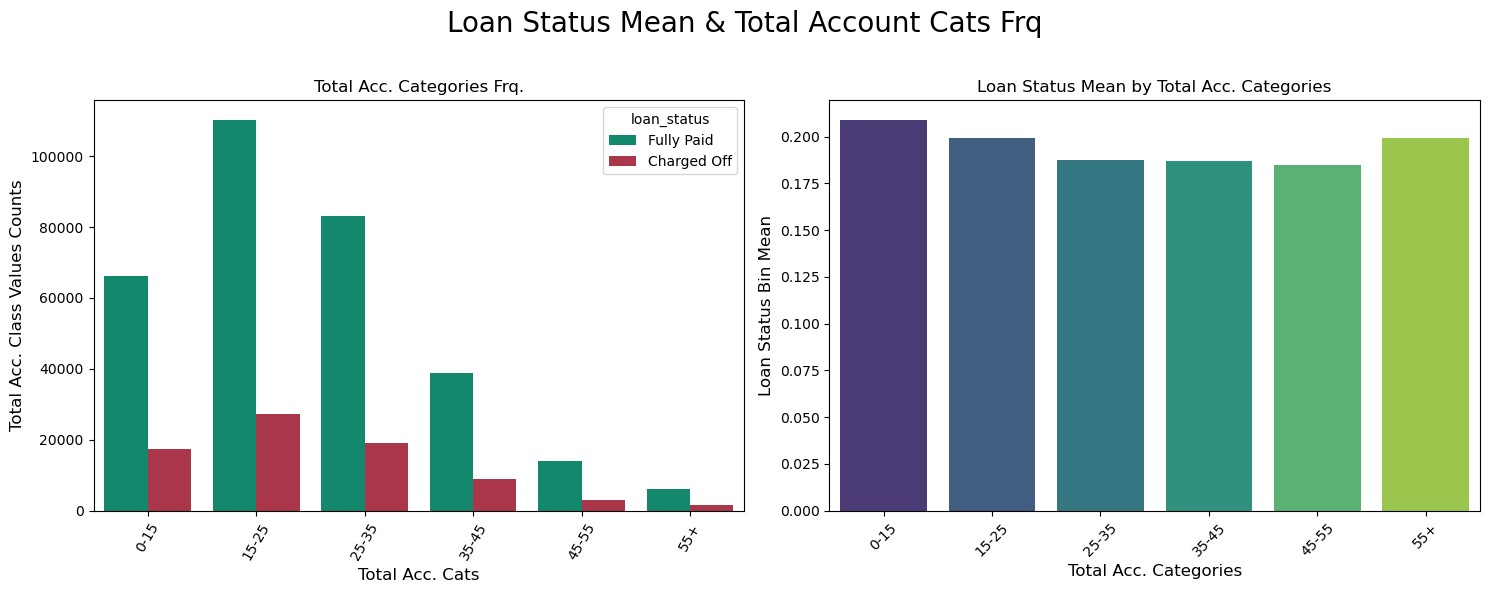

In [24]:
df['total_acc_cat'] = pd.cut(df['total_acc'], bins=[0, 15, 25, 35, 45, 55,float('inf') ], labels=['0-15', '15-25', '25-35', '35-45', '45-55', '55+'])

total_acc_gr = df.groupby('total_acc_cat').agg({'loan_status_bin':'mean'}).reset_index().sort_values(by = 'total_acc_cat', ascending= True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

fig.suptitle('Loan Status Mean & Total Account Cats Frq', fontsize = 20)
colors = ['#009B77','#BC243C']

sns.countplot(data=df, x='total_acc_cat', hue='loan_status', ax = axes[0],palette= colors)
axes[0].set_title('Total Acc. Categories Frq.', fontsize= 12)
axes[0].set_xlabel('Total Acc. Cats', fontsize = 12)
axes[0].set_ylabel('Total Acc. Class Values Counts', fontsize = 12)
axes[0].tick_params(axis='x', rotation=60)

sns.barplot(data = total_acc_gr, x = 'total_acc_cat', y = 'loan_status_bin', ax = axes[1], palette= 'viridis')
axes[1].set_title('Loan Status Mean by Total Acc. Categories', fontsize= 12)
axes[1].set_xlabel('Total Acc. Categories', fontsize = 12)
axes[1].set_ylabel('Loan Status Bin Mean', fontsize = 12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

1. Frequency Distribution of Total Account Number Categories (Left Graph)

- Observation: 

    * The vast majority of debtors have between 15-25 and 25-35 total accounts in their credit history. The data is concentrated in these middle categories. Those with very few accounts (‘0-15’) and those with very many accounts (‘45-55’, ‘55+’) are rarer.

- Analytical Comment: 

    * This distribution indicates that our borrower profile typically does not have either very new or excessively extensive credit histories. The majority consists of individuals with reasonable financial histories. This information provides a foundation for interpreting the risk graph on the right.

2. Default Rate by Total Number of Accounts (Right Graph)

- Observation: 

    * The relationship in this graph is quite interesting and exhibits a non-linear structure.

    * The highest default rate is seen in the ‘0-15’ group, which has the least credit experience.

    * As the total number of accounts increases (when moving to the ‘15-25’ group), the risk decreases significantly.

    * The default rate remains quite stable and low across the ‘15-25’, ‘25-35’, ‘35-45’, and ‘45-55’ categories.

    * In the most experienced group, the ‘55+’ category, a slight increase in the default rate is observed.

- Analytical Commentary:

    * This graph tells us a multi-layered story:

        * Inexperience Is the Biggest Risk: 
            - The group with the highest credit default risk is those with limited credit history. This makes perfect sense; because these borrowers are either younger or have had less interaction with the financial system, which makes their debt management experience and financial resilience more uncertain.

        * Maturity and Stability Phase: 
            - Once a borrower reaches a certain level of experience (more than 15 accounts in their history), their risk profile improves significantly and becomes more stable. Having more accounts beyond this point does not further reduce the risk.

        * Excessive Experience?: 
            - The slight increase in the ‘55+’ group may be noise due to the small sample size in this group or may indicate a slight increase in risk as it represents an older, now fixed-income (retired, etc.) population. However, the main conclusion is that risk is most concentrated in the inexperienced group.

The clear conclusion we draw from this analysis is that there is no linear relationship between the total number of credit accounts and the risk of default. The biggest risk factor is having an insufficient credit history.

In [25]:
df.loc[(df['total_acc']> df['total_acc'].quantile(0.97) ), 'total_acc'] = df['total_acc'].quantile(0.97)
df.loc[(df['open_acc']> df['open_acc'].quantile(0.99) ), 'open_acc'] = df['open_acc'].quantile(0.99)
df['open_total_acc_rate'] = np.where(df['total_acc'] == 0,0, df['open_acc'] / df['total_acc'])

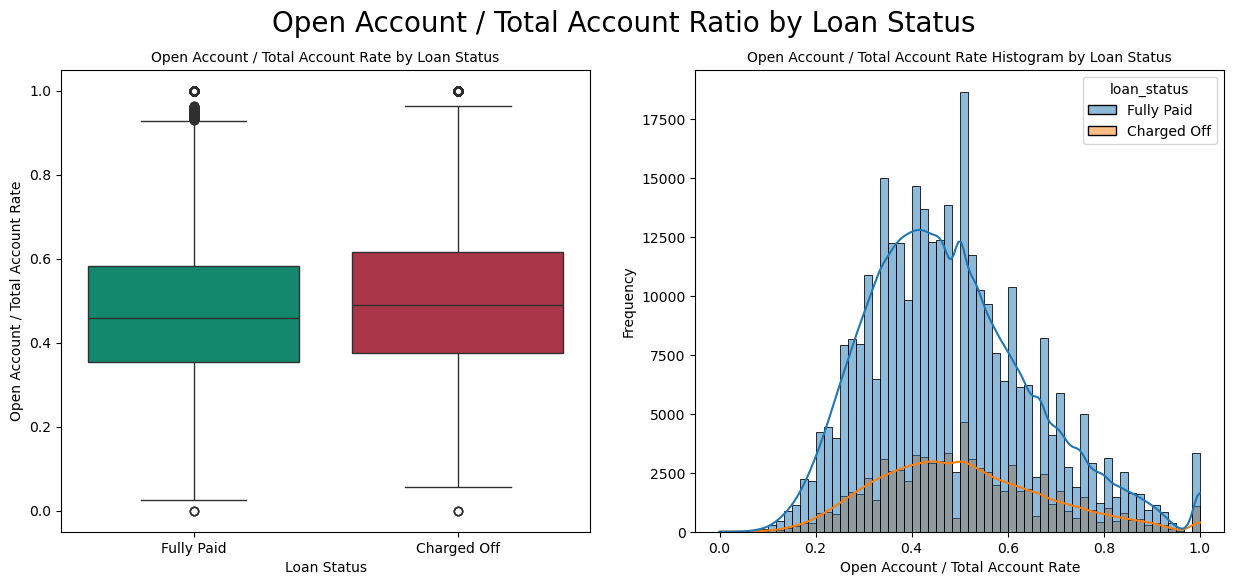

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

fig.suptitle('Open Account / Total Account Ratio by Loan Status', fontsize=20)
colors = ['#009B77','#BC243C']

sns.boxplot(x='loan_status', y='open_total_acc_rate', data=df, ax=axes[0], palette=colors)
axes[0].set_title('Open Account / Total Account Rate by Loan Status', fontsize=10)
axes[0].set_xlabel('Loan Status')
axes[0].set_ylabel('Open Account / Total Account Rate')

sns.histplot(data=df, x='open_total_acc_rate', hue='loan_status', kde=True, bins=60, ax=axes[1])
axes[1].set_title('Open Account / Total Account Rate Histogram by Loan Status', fontsize=10)
axes[1].set_xlabel('Open Account / Total Account Rate')
axes[1].set_ylabel('Frequency')


plt.show();

1. Box Plot (Left Side):

    - Observation: 
        * The box for the defaulted (Charged Off) group is clearly and distinctly positioned higher than that of the group that paid off their credit (Fully Paid).

    - Analytical Comment: 
        * This further confirms the accuracy of our hypothesis. More importantly, however, the distinction here is even sharper compared to our initial analysis using raw data. Cleaning out the outliers has allowed the true difference between the two groups to emerge more clearly. According to the cleaned data, the high open_total_acc_rate appears to be an even stronger signal for Charged Off.

2. Histogram (Right Side):

    - Observation: 
        * The histogram tells the same story. The distribution curve for the Charged Off group has shifted more noticeably to the right than the distribution curve for the Fully Paid group. The distance between the peaks of the two groups has widened further.

    - Analytical Comment: 
        * This visual confirms the ability of the open_total_acc_rate feature to distinguish borrowers with high Charged Off risk. By reducing the noise in the data, the underlying “signal” is now much brighter and clearer.

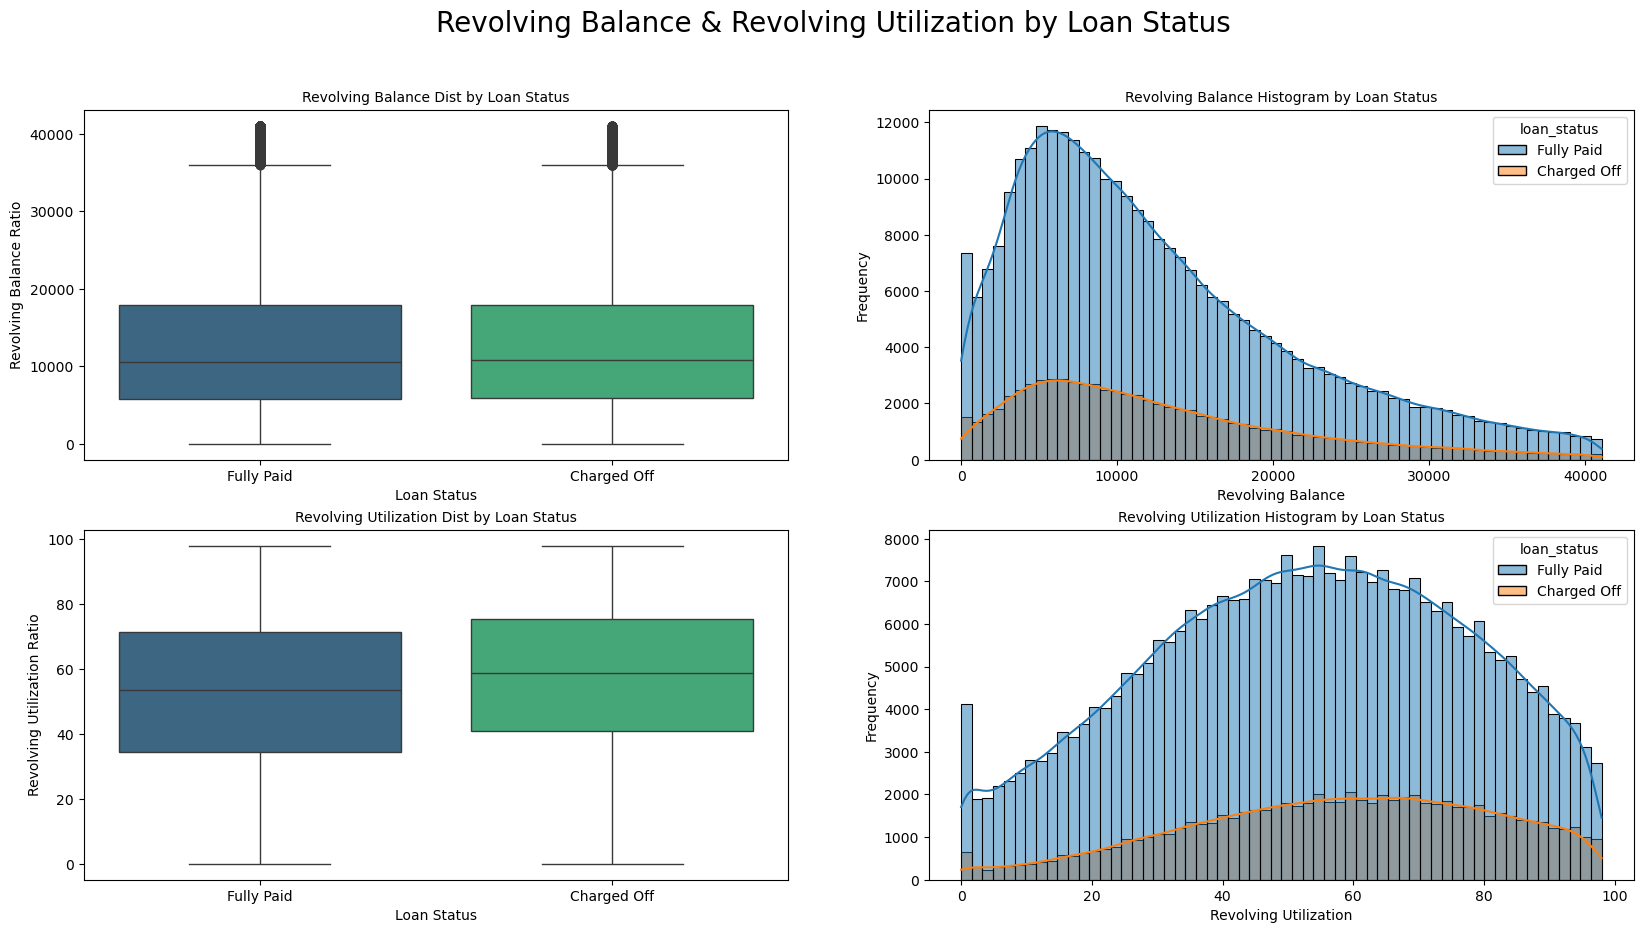

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

fig.suptitle('Revolving Balance & Revolving Utilization by Loan Status', fontsize=20)

sns.boxplot(x='loan_status', y='revol_bal', data=df[df['revol_bal']<=df['revol_bal'].quantile(0.95)], ax=axes[0,0], palette='viridis')
axes[0,0].set_title('Revolving Balance Dist by Loan Status', fontsize=10)
axes[0,0].set_xlabel('Loan Status')
axes[0,0].set_ylabel('Revolving Balance Ratio')

sns.histplot(data=df[df['revol_bal']<=df['revol_bal'].quantile(0.95)], x='revol_bal', hue='loan_status', kde=True, bins=60, ax=axes[0,1])
axes[0,1].set_title('Revolving Balance Histogram by Loan Status', fontsize=10)
axes[0,1].set_xlabel('Revolving Balance')
axes[0,1].set_ylabel('Frequency')

sns.boxplot(x='loan_status', y='revol_util', data=df[df['revol_util']<=df['revol_util'].quantile(0.99)], ax=axes[1,0], palette='viridis')
axes[1,0].set_title('Revolving Utilization Dist by Loan Status', fontsize=10)
axes[1,0].set_xlabel('Loan Status')
axes[1,0].set_ylabel('Revolving Utilization Ratio')

sns.histplot(data=df[df['revol_util']<=df['revol_util'].quantile(0.99)], x='revol_util', hue='loan_status', kde=True, bins=60, ax=axes[1,1])
axes[1,1].set_title('Revolving Utilization Histogram by Loan Status', fontsize=10)
axes[1,1].set_xlabel('Revolving Utilization')
axes[1,1].set_ylabel('Frequency')

plt.show();

1. Revolving Balance (Credit Card Debt Balance) Analysis (Top Two Graphs)

    - Observation:

        * Box Plot (Top Left): The box plots for both the “Fully Paid” and “Charged Off” groups are nearly identical. There is no significant difference between the median lines (the line in the middle of the boxes), the interquartile range (box size), and the distribution ranges (whiskers).

        * Histogram (Top Right): The distribution curves of the two groups also largely overlap. For both groups, the debt balance distribution is right-skewed, meaning most borrowers' balances are concentrated at low and medium levels. However, the distribution of bad debts does not clearly diverge from the distribution of paid debts.

    - Analytical Commentary:

        * These two graphs tell us one thing very clearly: The mere height of a borrower's credit card debt balance is not, by itself, a strong indicator for predicting the risk of that loan defaulting. A person with a low debt balance may still default on their loan, while another with a high debt balance may repay their debt without issue. There is no clear distinguishing power between the variables.

2. Revolving Utilization (Credit Card Usage Ratio) Analysis (The Two Graphs Below)

    - Observation:

        * Box Plot (Bottom Left): Here, the situation is completely different. The box for the “Charged Off” group is positioned significantly higher than the box for the “Fully Paid” group. The median utilization rate for the delinquent credit group is significantly higher than that of the paid group.

        * Histogram (Bottom Right): The distinction in this graph is even more striking. The distribution curve for the “Charged Off” group (orange) is clearly shifted to the right compared to the curve for the “Fully Paid” group (blue). This visually demonstrates that borrowers who default on their credit generally have higher credit card utilization rates.

    - Analytical Commentary:

        * Here's a critical finding for our project! The credit card utilization rate (revol_util) is a very powerful variable in predicting credit default risk. Borrowers who consistently use a large portion of their credit card limit are more likely to default on their loans.

        * Why Does This Make Sense? A high utilization rate may indicate that the borrower is financially strained, experiencing liquidity issues, and struggling to manage their existing debts. These individuals are vulnerable to unexpected expenses or even a small drop in income, putting them at risk of defaulting on new credit payments.

- Overall Assessment and Strategic Implications

    - When we combine these four graphs, the main story that emerges is this:

        * It's Not the Amount That Matters, It's the Ratio: When analyzing credit risk, what matters more than how much debt a person has (revol_bal) is the ratio of that debt to the limit offered to them (revol_util). A person with a credit card debt of $20,000 but a limit of $100,000 (20% utilization) may be much less risky than a person with a debt of $5,000 but a limit of $6,000 (83% utilization).

    - Impact on Modeling:

        * The revol_util variable is likely to be one of the most important features in the machine learning model you build. The model will establish a strong relationship between high revol_util values and high default probability.

        * The revol_bal variable, on its own, may have low predictive power. It will either be assigned a lower weight in the model or be combined with other variables (feature engineering) to make it meaningful.

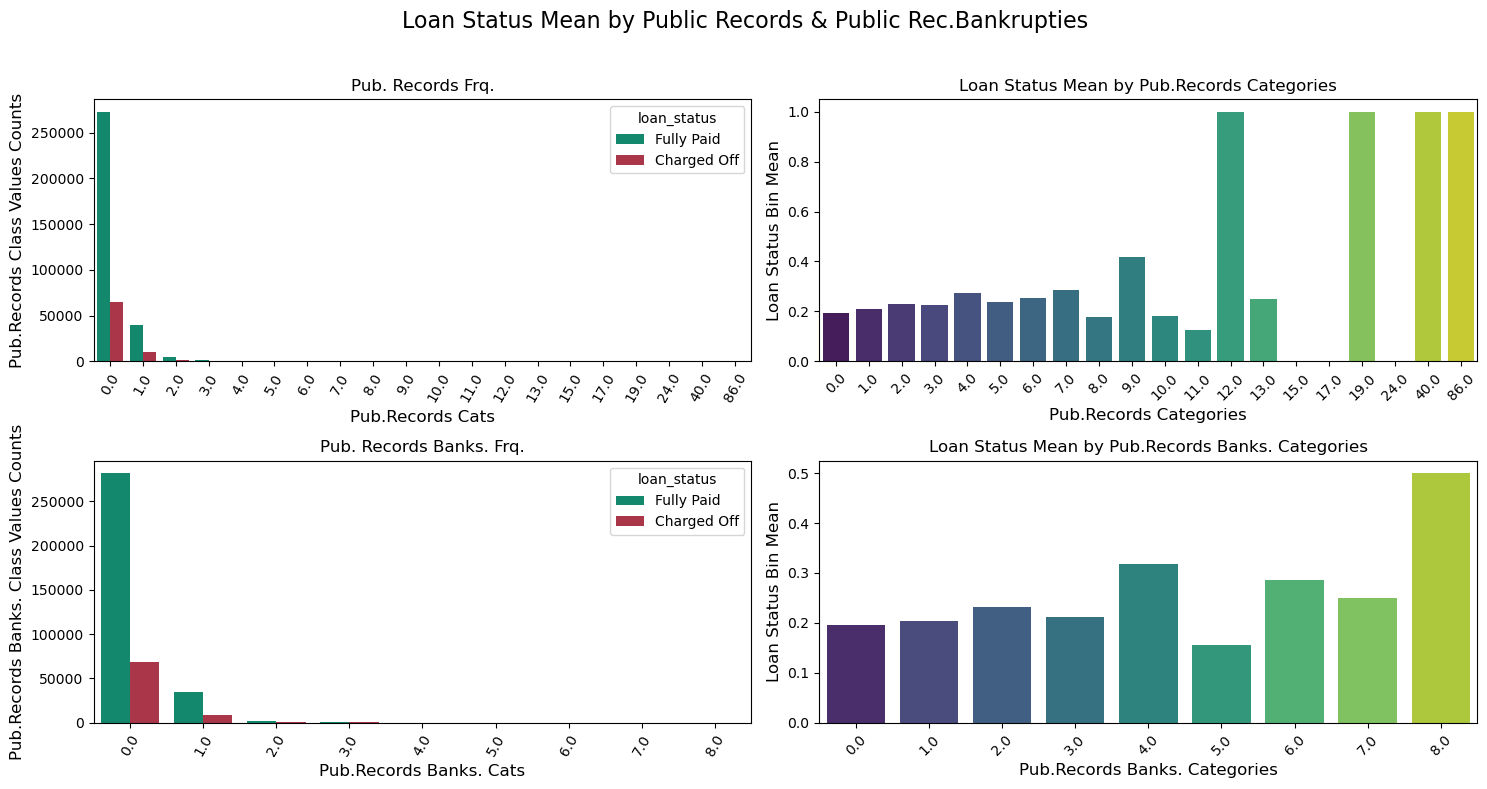

In [28]:
pub_rec_gr = df.groupby('pub_rec').agg({'loan_status_bin':'mean'}).reset_index().sort_values(by = 'pub_rec', ascending= True)
pub_rec_bank_gr = df.groupby('pub_rec_bankruptcies').agg({'loan_status_bin':'mean'}).reset_index().sort_values(by = 'pub_rec_bankruptcies', ascending= True)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))

fig.suptitle('Loan Status Mean by Public Records & Public Rec.Bankrupties', fontsize = 16)
colors = ['#009B77','#BC243C']

sns.countplot(data=df, x='pub_rec', hue='loan_status', ax = axes[0,0],palette= colors)
axes[0,0].set_title('Pub. Records Frq.', fontsize= 12)
axes[0,0].set_xlabel('Pub.Records Cats', fontsize = 12)
axes[0,0].set_ylabel('Pub.Records Class Values Counts', fontsize = 12)
axes[0,0].tick_params(axis='x', rotation=60)

sns.barplot(data = pub_rec_gr, x = 'pub_rec', y = 'loan_status_bin', ax = axes[0,1], palette= 'viridis')
axes[0,1].set_title('Loan Status Mean by Pub.Records Categories', fontsize= 12)
axes[0,1].set_xlabel('Pub.Records Categories', fontsize = 12)
axes[0,1].set_ylabel('Loan Status Bin Mean', fontsize = 12)
axes[0,1].tick_params(axis='x', rotation=45)

sns.countplot(data=df, x='pub_rec_bankruptcies', hue='loan_status', ax = axes[1,0],palette= colors)
axes[1,0].set_title('Pub. Records Banks. Frq.', fontsize= 12)
axes[1,0].set_xlabel('Pub.Records Banks. Cats', fontsize = 12)
axes[1,0].set_ylabel('Pub.Records Banks. Class Values Counts', fontsize = 12)
axes[1,0].tick_params(axis='x', rotation=60)

sns.barplot(data = pub_rec_bank_gr, x = 'pub_rec_bankruptcies', y = 'loan_status_bin', ax = axes[1,1], palette= 'viridis')
axes[1,1].set_title('Loan Status Mean by Pub.Records Banks. Categories', fontsize= 12)
axes[1,1].set_xlabel('Pub.Records Banks. Categories', fontsize = 12)
axes[1,1].set_ylabel('Loan Status Bin Mean', fontsize = 12)
axes[1,1].tick_params(axis='x', rotation=45)


plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

- 1. pub_rec (Public Records) Analysis (Top Graphs)

    * Frequency Chart (Top Left): This chart visually confirms what we saw in our previous statistical summary: the overwhelming majority of debtors have no public records (0). The number of those with 1, 2, or more records is so small that they are barely visible on the chart.

    * Default Rate Chart (Top Right): This chart provides the most important information.

    * The default rate for those with no public records is close to the overall average for the data set (approximately 19%).

        - However, having even one (1) public record significantly increases the default rate to approximately 28%.

        - The rates for those with 2 or more records also appear high, but the statistical reliability of these rates is low because the number of individuals in these groups is very small.

- 2. pub_rec_bankruptcies (Bankruptcy Records) Analysis (Lower Graphs)

    * Frequency Graph (Lower Left): We see almost the same story as with pub_rec. A very large portion of debtors have no bankruptcy records (0).

    * Default Rate Chart (Bottom Right): The trend here is also very similar and clear.

    * The default rate for those with no bankruptcy records is again at the base level.

    * However, having just one (1) bankruptcy record again significantly increases the default rate.

    * The ratio for those with two bankruptcy records appears even higher, but again, the sample size in this group is very small.

- Overall Assessment and Strategic Implications 🎯

    * The analysis of these two variables gives us a common and very clear result:

    * pub_rec and pub_rec_bankruptcies are “rare event” type predictive variables. That is, they are not found in the majority of the population, but when they are present, they give a very strong negative signal for default risk.

    * The most important information in these variables is the sharp distinction between a person having 0 records and having 1 or more records. The difference between 1 record and 2 records is not as meaningful and reliable as the difference between 0 and 1.
